# Neural Net Modeling
In continuing with modeling, I want to see if I can better my scores and skipped song finds using Neural Networks. I will use the Keras library with the pre-processing tokenizer.



#### Table of Contents
<br>`Pre-Processing`</br>

- [Baseline](#base)
- [Tokenizer](#token)

<br>`Modeling`</br>

- [MultinomialNB](#Mnb)
- [BernoulliNB](#Bnb)
- [Logistic Regression](#Lg)
- [Ada Boost](#ada)
- [Random Forest](#forest)

<br>`Conclusion`</br>

- [Feat Importance of Best Model](#feat)
- [Notebook Conclusion](#conc)    

### Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text # to add more stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Precision, Recall, AUC, Accuracy
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
df = pd.read_csv('./data/lyrics_cleaned.csv')

### Baseline<a id='base'></a>  
Continuing with using confusion matrix and f1 score to have close in-depth look at how the neural network is scoring with my imbalanced data.

In [3]:
neg, pos = np.bincount(df['skip'])
total = neg + pos
print(f"Total: {total}\n    Skipped(1) count is: {pos} ({100 * pos / total:.2f}% of total)\n   Not Skipped(0) count is: {neg} ({100 * neg / total:.2f}% of total)\n")

Total: 11455
    Skipped(1) count is: 2750 (24.01% of total)
   Not Skipped(0) count is: 8705 (75.99% of total)



Again changing some words to a more vague term

In [4]:
some_words = open("./data/drop_words.txt").read().split()

for i in some_words:   
    df['lyrics'] = df['lyrics'].str.lower().str.replace(rf"\b{i}\b", 'vulgar')

### Train Test Split
Tokenizer to create a Bag of Words, then train, test, split followed by standard scaler

In [5]:
X = df['lyrics']
y = df['skip']

### Tokenizer<a id='token'></a>

In [6]:
token = Tokenizer()
token.fit_on_texts(X)
encode_X = token.texts_to_matrix(X, mode='count')

In [7]:
# since the categories are unbalanced I will stratify y
X_train, X_test, y_train, y_test = train_test_split(encode_X, y, random_state=42, stratify=y) 
# Check shapes of the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8591, 58899), (2864, 58899), (8591,), (2864,))

In [8]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Re-Weighting
Because my classes as so imbalanced (76%, 24%) I want to re-weigh my classes, so that the smaller class has a heavier weight 

In [9]:

weight_for_0 = (1 / neg)*(total)/2.0  # /2 helps keep the loss to similar size
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1} # mapping the weights

print(f'Weight for class 0: {weight_for_0 :.2f}')
print(f'Weight for class 1: {weight_for_1 :.2f}')

Weight for class 0: 0.66
Weight for class 1: 2.08


Again due to the imbalance factor, looking at accuracy alone is not a good metric, so getting better insight with recall, precision, AUC and confusion matrix will tell me how well my model is doing

In [10]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      Accuracy(name='accuracy')]


### Gridsearching  Keras Classifier

In [23]:
def create_model(optimizer='adam'): # creating a model function
    model = Sequential() # instantiate model
    model.add(Dense(15, # first layer
                    input_dim=X_train_sc.shape[1], # shape of X_train_sc
                    #kernel_initializer=init_mode, # starting weight
                    activation='relu'))
    model.add(Dense(1, # exit layer
                    #kernel_initializer=init_mode, # final weight
                    activation='sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer=optimizer,  metrics=METRICS) 
    # metrics is defined is previous cell, optimizer is initialized at adam and kernel_initializer at uniform, the gridsearch
    # will overwrite these as it searches for best params.
    return model

In [24]:
# using keras wrappers we can 'trick' it into allowing us to gridsearch a Keras Classifier
model = KerasClassifier(build_fn=create_model, verbose=1)
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [25]:
# grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
# feeding into gridsearch

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

In [ ]:
grid_result = grid.fit(X_train_sc, y_train, epochs=100, verbose=1, validation_data=(X_test_sc, y_test), class_weight=class_weight, batch_size=100) 
# because my biggest issue is that validation loss keeps increasing, I wanted to make sure I add validation data for score output.
# class is being re-weighted for hopefully better scores

#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # returns best score and best params


Epoch 1/100
58/58 [==============================] - 2s 32ms/step - loss: 0.9170 - tp: 717.0000 - fp: 575.0000 - tn: 5967.0000 - fn: 1332.0000 - precision: 0.5550 - recall: 0.3499 - auc: 0.6964 - accuracy: 0.0389 - val_loss: 0.5267 - val_tp: 384.0000 - val_fp: 313.0000 - val_tn: 1863.0000 - val_fn: 304.0000 - val_precision: 0.5509 - val_recall: 0.5581 - val_auc: 0.8055 - val_accuracy: 0.0010
Epoch 2/100
58/58 [==============================] - 1s 16ms/step - loss: 0.1819 - tp: 1277.0000 - fp: 99.0000 - tn: 4267.0000 - fn: 84.0000 - precision: 0.9281 - recall: 0.9383 - auc: 0.9914 - accuracy: 0.0063 - val_loss: 0.5307 - val_tp: 386.0000 - val_fp: 301.0000 - val_tn: 1875.0000 - val_fn: 302.0000 - val_precision: 0.5619 - val_recall: 0.5610 - val_auc: 0.8053 - val_accuracy: 0.0014
Epoch 3/100
58/58 [==============================] - 1s 16ms/step - loss: 0.1265 - tp: 1329.0000 - fp: 25.0000 - tn: 4341.0000 - fn: 32.0000 - precision: 0.9815 - recall: 0.9765 - auc: 0.9986 - accuracy: 0.0066 -

Epoch 22/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0191 - tp: 1361.0000 - fp: 6.0000 - tn: 4360.0000 - fn: 0.0000e+00 - precision: 0.9956 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0124 - val_loss: 0.6609 - val_tp: 430.0000 - val_fp: 356.0000 - val_tn: 1820.0000 - val_fn: 258.0000 - val_precision: 0.5471 - val_recall: 0.6250 - val_auc: 0.8272 - val_accuracy: 0.0028
Epoch 23/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0183 - tp: 1361.0000 - fp: 6.0000 - tn: 4360.0000 - fn: 0.0000e+00 - precision: 0.9956 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0126 - val_loss: 0.6650 - val_tp: 430.0000 - val_fp: 357.0000 - val_tn: 1819.0000 - val_fn: 258.0000 - val_precision: 0.5464 - val_recall: 0.6250 - val_auc: 0.8275 - val_accuracy: 0.0028
Epoch 24/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0176 - tp: 1361.0000 - fp: 7.0000 - tn: 4359.0000 - fn: 0.0000e+00 - precision: 0.9949 - recall: 1.0000 - auc: 1.0000 - accuracy: 0

Epoch 43/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0106 - tp: 1361.0000 - fp: 4.0000 - tn: 4362.0000 - fn: 0.0000e+00 - precision: 0.9971 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0150 - val_loss: 0.7245 - val_tp: 442.0000 - val_fp: 377.0000 - val_tn: 1799.0000 - val_fn: 246.0000 - val_precision: 0.5397 - val_recall: 0.6424 - val_auc: 0.8287 - val_accuracy: 0.0045
Epoch 44/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0104 - tp: 1361.0000 - fp: 4.0000 - tn: 4362.0000 - fn: 0.0000e+00 - precision: 0.9971 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0150 - val_loss: 0.7267 - val_tp: 443.0000 - val_fp: 377.0000 - val_tn: 1799.0000 - val_fn: 245.0000 - val_precision: 0.5402 - val_recall: 0.6439 - val_auc: 0.8288 - val_accuracy: 0.0045
Epoch 45/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0103 - tp: 1361.0000 - fp: 4.0000 - tn: 4362.0000 - fn: 0.0000e+00 - precision: 0.9971 - recall: 1.0000 - auc: 1.0000 - accuracy: 0

Epoch 64/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0081 - tp: 1361.0000 - fp: 4.0000 - tn: 4362.0000 - fn: 0.0000e+00 - precision: 0.9971 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0157 - val_loss: 0.7627 - val_tp: 447.0000 - val_fp: 382.0000 - val_tn: 1794.0000 - val_fn: 241.0000 - val_precision: 0.5392 - val_recall: 0.6497 - val_auc: 0.8293 - val_accuracy: 0.0052
Epoch 65/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0081 - tp: 1361.0000 - fp: 4.0000 - tn: 4362.0000 - fn: 0.0000e+00 - precision: 0.9971 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0157 - val_loss: 0.7642 - val_tp: 447.0000 - val_fp: 382.0000 - val_tn: 1794.0000 - val_fn: 241.0000 - val_precision: 0.5392 - val_recall: 0.6497 - val_auc: 0.8288 - val_accuracy: 0.0052
Epoch 66/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0080 - tp: 1361.0000 - fp: 4.0000 - tn: 4362.0000 - fn: 0.0000e+00 - precision: 0.9971 - recall: 1.0000 - auc: 1.0000 - accuracy: 0

Epoch 85/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0070 - tp: 1361.0000 - fp: 4.0000 - tn: 4362.0000 - fn: 0.0000e+00 - precision: 0.9971 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0171 - val_loss: 0.7900 - val_tp: 450.0000 - val_fp: 386.0000 - val_tn: 1790.0000 - val_fn: 238.0000 - val_precision: 0.5383 - val_recall: 0.6541 - val_auc: 0.8281 - val_accuracy: 0.0052
Epoch 86/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0070 - tp: 1361.0000 - fp: 4.0000 - tn: 4362.0000 - fn: 0.0000e+00 - precision: 0.9971 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0171 - val_loss: 0.7911 - val_tp: 450.0000 - val_fp: 386.0000 - val_tn: 1790.0000 - val_fn: 238.0000 - val_precision: 0.5383 - val_recall: 0.6541 - val_auc: 0.8280 - val_accuracy: 0.0052
Epoch 87/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0069 - tp: 1361.0000 - fp: 4.0000 - tn: 4362.0000 - fn: 0.0000e+00 - precision: 0.9971 - recall: 1.0000 - auc: 1.0000 - accuracy: 0

58/58 [==============================] - 1s 16ms/step - loss: 0.0584 - tp: 1386.0000 - fp: 5.0000 - tn: 4326.0000 - fn: 10.0000 - precision: 0.9964 - recall: 0.9928 - auc: 0.9999 - accuracy: 0.0073 - val_loss: 0.6115 - val_tp: 487.0000 - val_fp: 437.0000 - val_tn: 1739.0000 - val_fn: 201.0000 - val_precision: 0.5271 - val_recall: 0.7078 - val_auc: 0.8218 - val_accuracy: 0.0010
Epoch 6/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0475 - tp: 1388.0000 - fp: 2.0000 - tn: 4329.0000 - fn: 8.0000 - precision: 0.9986 - recall: 0.9943 - auc: 0.9999 - accuracy: 0.0075 - val_loss: 0.6168 - val_tp: 488.0000 - val_fp: 432.0000 - val_tn: 1744.0000 - val_fn: 200.0000 - val_precision: 0.5304 - val_recall: 0.7093 - val_auc: 0.8238 - val_accuracy: 0.0010
Epoch 7/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0397 - tp: 1389.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 7.0000 - precision: 1.0000 - recall: 0.9950 - auc: 1.0000 - accuracy: 0.0079 - val_loss: 0.62

Epoch 26/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0088 - tp: 1393.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9979 - auc: 1.0000 - accuracy: 0.0107 - val_loss: 0.7079 - val_tp: 492.0000 - val_fp: 422.0000 - val_tn: 1754.0000 - val_fn: 196.0000 - val_precision: 0.5383 - val_recall: 0.7151 - val_auc: 0.8343 - val_accuracy: 0.0024
Epoch 27/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0084 - tp: 1393.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9979 - auc: 1.0000 - accuracy: 0.0107 - val_loss: 0.7109 - val_tp: 492.0000 - val_fp: 423.0000 - val_tn: 1753.0000 - val_fn: 196.0000 - val_precision: 0.5377 - val_recall: 0.7151 - val_auc: 0.8345 - val_accuracy: 0.0024
Epoch 28/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0081 - tp: 1393.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9979 - auc: 1.0000 - accuracy: 0

Epoch 47/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0050 - tp: 1393.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9979 - auc: 1.0000 - accuracy: 0.0117 - val_loss: 0.7550 - val_tp: 494.0000 - val_fp: 421.0000 - val_tn: 1755.0000 - val_fn: 194.0000 - val_precision: 0.5399 - val_recall: 0.7180 - val_auc: 0.8363 - val_accuracy: 0.0031
Epoch 48/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0049 - tp: 1393.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9979 - auc: 1.0000 - accuracy: 0.0117 - val_loss: 0.7567 - val_tp: 494.0000 - val_fp: 421.0000 - val_tn: 1755.0000 - val_fn: 194.0000 - val_precision: 0.5399 - val_recall: 0.7180 - val_auc: 0.8363 - val_accuracy: 0.0031
Epoch 49/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0048 - tp: 1393.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9979 - auc: 1.0000 - accuracy: 0

Epoch 68/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0037 - tp: 1393.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9979 - auc: 1.0000 - accuracy: 0.0133 - val_loss: 0.7854 - val_tp: 495.0000 - val_fp: 420.0000 - val_tn: 1756.0000 - val_fn: 193.0000 - val_precision: 0.5410 - val_recall: 0.7195 - val_auc: 0.8366 - val_accuracy: 0.0035
Epoch 69/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0037 - tp: 1393.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9979 - auc: 1.0000 - accuracy: 0.0133 - val_loss: 0.7866 - val_tp: 495.0000 - val_fp: 420.0000 - val_tn: 1756.0000 - val_fn: 193.0000 - val_precision: 0.5410 - val_recall: 0.7195 - val_auc: 0.8367 - val_accuracy: 0.0035
Epoch 70/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0036 - tp: 1393.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9979 - auc: 1.0000 - accuracy: 0

Epoch 89/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0031 - tp: 1393.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9979 - auc: 1.0000 - accuracy: 0.0141 - val_loss: 0.8075 - val_tp: 495.0000 - val_fp: 417.0000 - val_tn: 1759.0000 - val_fn: 193.0000 - val_precision: 0.5428 - val_recall: 0.7195 - val_auc: 0.8366 - val_accuracy: 0.0038
Epoch 90/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0031 - tp: 1393.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9979 - auc: 1.0000 - accuracy: 0.0141 - val_loss: 0.8084 - val_tp: 495.0000 - val_fp: 416.0000 - val_tn: 1760.0000 - val_fn: 193.0000 - val_precision: 0.5434 - val_recall: 0.7195 - val_auc: 0.8363 - val_accuracy: 0.0038
Epoch 91/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0031 - tp: 1393.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9979 - auc: 1.0000 - accuracy: 0

58/58 [==============================] - 1s 16ms/step - loss: 0.0419 - tp: 1364.0000 - fp: 2.0000 - tn: 4359.0000 - fn: 3.0000 - precision: 0.9985 - recall: 0.9978 - auc: 1.0000 - accuracy: 0.0017 - val_loss: 0.6282 - val_tp: 487.0000 - val_fp: 468.0000 - val_tn: 1708.0000 - val_fn: 201.0000 - val_precision: 0.5099 - val_recall: 0.7078 - val_auc: 0.8277 - val_accuracy: 6.9832e-04
Epoch 10/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0362 - tp: 1365.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 2.0000 - precision: 0.9993 - recall: 0.9985 - auc: 1.0000 - accuracy: 0.0017 - val_loss: 0.6315 - val_tp: 486.0000 - val_fp: 465.0000 - val_tn: 1711.0000 - val_fn: 202.0000 - val_precision: 0.5110 - val_recall: 0.7064 - val_auc: 0.8285 - val_accuracy: 6.9832e-04
Epoch 11/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0317 - tp: 1366.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 1.0000 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.0017 - val_loss:

Epoch 30/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0085 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0026 - val_loss: 0.6959 - val_tp: 475.0000 - val_fp: 430.0000 - val_tn: 1746.0000 - val_fn: 213.0000 - val_precision: 0.5249 - val_recall: 0.6904 - val_auc: 0.8336 - val_accuracy: 0.0014
Epoch 31/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0082 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0026 - val_loss: 0.6982 - val_tp: 475.0000 - val_fp: 429.0000 - val_tn: 1747.0000 - val_fn: 213.0000 - val_precision: 0.5254 - val_recall: 0.6904 - val_auc: 0.8337 - val_accuracy: 0.0014
Epoch 32/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0079 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 -

58/58 [==============================] - 1s 17ms/step - loss: 0.0048 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0030 - val_loss: 0.7327 - val_tp: 472.0000 - val_fp: 419.0000 - val_tn: 1757.0000 - val_fn: 216.0000 - val_precision: 0.5297 - val_recall: 0.6860 - val_auc: 0.8347 - val_accuracy: 0.0021
Epoch 51/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0047 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0030 - val_loss: 0.7341 - val_tp: 472.0000 - val_fp: 417.0000 - val_tn: 1759.0000 - val_fn: 216.0000 - val_precision: 0.5309 - val_recall: 0.6860 - val_auc: 0.8349 - val_accuracy: 0.0021
Epoch 52/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0046 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.

58/58 [==============================] - 1s 17ms/step - loss: 0.0034 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0031 - val_loss: 0.7569 - val_tp: 468.0000 - val_fp: 407.0000 - val_tn: 1769.0000 - val_fn: 220.0000 - val_precision: 0.5349 - val_recall: 0.6802 - val_auc: 0.8355 - val_accuracy: 0.0021
Epoch 71/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0034 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0031 - val_loss: 0.7580 - val_tp: 468.0000 - val_fp: 407.0000 - val_tn: 1769.0000 - val_fn: 220.0000 - val_precision: 0.5349 - val_recall: 0.6802 - val_auc: 0.8356 - val_accuracy: 0.0021
Epoch 72/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0033 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.

58/58 [==============================] - 1s 16ms/step - loss: 0.0027 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0035 - val_loss: 0.7753 - val_tp: 464.0000 - val_fp: 409.0000 - val_tn: 1767.0000 - val_fn: 224.0000 - val_precision: 0.5315 - val_recall: 0.6744 - val_auc: 0.8345 - val_accuracy: 0.0024
Epoch 91/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0026 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0035 - val_loss: 0.7761 - val_tp: 464.0000 - val_fp: 409.0000 - val_tn: 1767.0000 - val_fn: 224.0000 - val_precision: 0.5315 - val_recall: 0.6744 - val_auc: 0.8345 - val_accuracy: 0.0024
Epoch 92/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0026 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.

58/58 [==============================] - 1s 21ms/step - loss: 0.2423 - tp: 1326.0000 - fp: 78.0000 - tn: 4288.0000 - fn: 35.0000 - precision: 0.9444 - recall: 0.9743 - auc: 0.9890 - accuracy: 0.2445 - val_loss: 12.3743 - val_tp: 366.0000 - val_fp: 564.0000 - val_tn: 1612.0000 - val_fn: 322.0000 - val_precision: 0.3935 - val_recall: 0.5320 - val_auc: 0.5689 - val_accuracy: 0.1260
Epoch 11/100
58/58 [==============================] - 1s 21ms/step - loss: 0.1963 - tp: 1336.0000 - fp: 17.0000 - tn: 4349.0000 - fn: 25.0000 - precision: 0.9874 - recall: 0.9816 - auc: 0.9934 - accuracy: 0.2504 - val_loss: 10.8137 - val_tp: 383.0000 - val_fp: 603.0000 - val_tn: 1573.0000 - val_fn: 305.0000 - val_precision: 0.3884 - val_recall: 0.5567 - val_auc: 0.5842 - val_accuracy: 0.1201
Epoch 12/100
58/58 [==============================] - 1s 21ms/step - loss: 0.3437 - tp: 1322.0000 - fp: 86.0000 - tn: 4280.0000 - fn: 39.0000 - precision: 0.9389 - recall: 0.9713 - auc: 0.9825 - accuracy: 0.2315 - val_loss:

Epoch 31/100
58/58 [==============================] - 1s 21ms/step - loss: 0.1258 - tp: 1267.0000 - fp: 1.0000 - tn: 4365.0000 - fn: 94.0000 - precision: 0.9992 - recall: 0.9309 - auc: 0.9754 - accuracy: 0.2947 - val_loss: 20.1830 - val_tp: 529.0000 - val_fp: 512.0000 - val_tn: 1664.0000 - val_fn: 159.0000 - val_precision: 0.5082 - val_recall: 0.7689 - val_auc: 0.7710 - val_accuracy: 0.1533
Epoch 32/100
58/58 [==============================] - 1s 20ms/step - loss: 0.1243 - tp: 1267.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 94.0000 - precision: 1.0000 - recall: 0.9309 - auc: 0.9748 - accuracy: 0.2974 - val_loss: 20.0015 - val_tp: 529.0000 - val_fp: 513.0000 - val_tn: 1663.0000 - val_fn: 159.0000 - val_precision: 0.5077 - val_recall: 0.7689 - val_auc: 0.7709 - val_accuracy: 0.1543
Epoch 33/100
58/58 [==============================] - 1s 21ms/step - loss: 0.1229 - tp: 1267.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 94.0000 - precision: 1.0000 - recall: 0.9309 - auc: 0.9751 - accuracy: 

Epoch 52/100
58/58 [==============================] - 1s 21ms/step - loss: 0.1120 - tp: 1267.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 94.0000 - precision: 1.0000 - recall: 0.9309 - auc: 0.9765 - accuracy: 0.3414 - val_loss: 17.7590 - val_tp: 502.0000 - val_fp: 440.0000 - val_tn: 1736.0000 - val_fn: 186.0000 - val_precision: 0.5329 - val_recall: 0.7297 - val_auc: 0.7672 - val_accuracy: 0.1606
Epoch 53/100
58/58 [==============================] - 1s 22ms/step - loss: 0.1120 - tp: 1267.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 94.0000 - precision: 1.0000 - recall: 0.9309 - auc: 0.9777 - accuracy: 0.3449 - val_loss: 17.6473 - val_tp: 502.0000 - val_fp: 441.0000 - val_tn: 1735.0000 - val_fn: 186.0000 - val_precision: 0.5323 - val_recall: 0.7297 - val_auc: 0.7670 - val_accuracy: 0.1599
Epoch 54/100
58/58 [==============================] - 1s 23ms/step - loss: 0.1120 - tp: 1267.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 94.0000 - precision: 1.0000 - recall: 0.9309 - auc: 0.9783 - accura

Epoch 73/100
58/58 [==============================] - 1s 21ms/step - loss: 0.1088 - tp: 1268.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 93.0000 - precision: 1.0000 - recall: 0.9317 - auc: 0.9799 - accuracy: 0.3679 - val_loss: 17.5881 - val_tp: 473.0000 - val_fp: 388.0000 - val_tn: 1788.0000 - val_fn: 215.0000 - val_precision: 0.5494 - val_recall: 0.6875 - val_auc: 0.7505 - val_accuracy: 0.1662
Epoch 74/100
58/58 [==============================] - 1s 20ms/step - loss: 0.1084 - tp: 1268.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 93.0000 - precision: 1.0000 - recall: 0.9317 - auc: 0.9802 - accuracy: 0.3571 - val_loss: 17.4955 - val_tp: 478.0000 - val_fp: 408.0000 - val_tn: 1768.0000 - val_fn: 210.0000 - val_precision: 0.5395 - val_recall: 0.6948 - val_auc: 0.7541 - val_accuracy: 0.1666
Epoch 75/100
58/58 [==============================] - 1s 20ms/step - loss: 0.1083 - tp: 1268.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 93.0000 - precision: 1.0000 - recall: 0.9317 - auc: 0.9801 - accura

Epoch 94/100
58/58 [==============================] - 1s 20ms/step - loss: 0.1083 - tp: 1269.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 92.0000 - precision: 1.0000 - recall: 0.9324 - auc: 0.9805 - accuracy: 0.3773 - val_loss: 17.4123 - val_tp: 470.0000 - val_fp: 391.0000 - val_tn: 1785.0000 - val_fn: 218.0000 - val_precision: 0.5459 - val_recall: 0.6831 - val_auc: 0.7472 - val_accuracy: 0.1725
Epoch 95/100
58/58 [==============================] - 1s 21ms/step - loss: 0.1063 - tp: 1269.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 92.0000 - precision: 1.0000 - recall: 0.9324 - auc: 0.9812 - accuracy: 0.3773 - val_loss: 17.4556 - val_tp: 470.0000 - val_fp: 392.0000 - val_tn: 1784.0000 - val_fn: 218.0000 - val_precision: 0.5452 - val_recall: 0.6831 - val_auc: 0.7489 - val_accuracy: 0.1721
Epoch 96/100
58/58 [==============================] - 1s 21ms/step - loss: 0.1064 - tp: 1269.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 92.0000 - precision: 1.0000 - recall: 0.9324 - auc: 0.9812 - accura

58/58 [==============================] - 1s 22ms/step - loss: 0.1964 - tp: 1346.0000 - fp: 22.0000 - tn: 4309.0000 - fn: 50.0000 - precision: 0.9839 - recall: 0.9642 - auc: 0.9862 - accuracy: 0.2258 - val_loss: 6.4416 - val_tp: 483.0000 - val_fp: 443.0000 - val_tn: 1733.0000 - val_fn: 205.0000 - val_precision: 0.5216 - val_recall: 0.7020 - val_auc: 0.7257 - val_accuracy: 0.1229
Epoch 15/100
58/58 [==============================] - 1s 21ms/step - loss: 0.1714 - tp: 1350.0000 - fp: 5.0000 - tn: 4326.0000 - fn: 46.0000 - precision: 0.9963 - recall: 0.9670 - auc: 0.9896 - accuracy: 0.2258 - val_loss: 6.5677 - val_tp: 487.0000 - val_fp: 453.0000 - val_tn: 1723.0000 - val_fn: 201.0000 - val_precision: 0.5181 - val_recall: 0.7078 - val_auc: 0.7267 - val_accuracy: 0.1250
Epoch 16/100
58/58 [==============================] - 1s 21ms/step - loss: 0.1630 - tp: 1352.0000 - fp: 4.0000 - tn: 4327.0000 - fn: 44.0000 - precision: 0.9971 - recall: 0.9685 - auc: 0.9890 - accuracy: 0.2273 - val_loss: 6.5

Epoch 35/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0496 - tp: 1360.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 36.0000 - precision: 1.0000 - recall: 0.9742 - auc: 0.9962 - accuracy: 0.3002 - val_loss: 9.9788 - val_tp: 398.0000 - val_fp: 354.0000 - val_tn: 1822.0000 - val_fn: 290.0000 - val_precision: 0.5293 - val_recall: 0.5785 - val_auc: 0.6770 - val_accuracy: 0.1459
Epoch 36/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0471 - tp: 1360.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 36.0000 - precision: 1.0000 - recall: 0.9742 - auc: 0.9966 - accuracy: 0.3019 - val_loss: 10.1553 - val_tp: 397.0000 - val_fp: 353.0000 - val_tn: 1823.0000 - val_fn: 291.0000 - val_precision: 0.5293 - val_recall: 0.5770 - val_auc: 0.6701 - val_accuracy: 0.1466
Epoch 37/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0460 - tp: 1360.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 36.0000 - precision: 1.0000 - recall: 0.9742 - auc: 0.9969 - accurac

Epoch 56/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0277 - tp: 1362.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 34.0000 - precision: 1.0000 - recall: 0.9756 - auc: 0.9993 - accuracy: 0.3379 - val_loss: 11.2124 - val_tp: 383.0000 - val_fp: 337.0000 - val_tn: 1839.0000 - val_fn: 305.0000 - val_precision: 0.5319 - val_recall: 0.5567 - val_auc: 0.6948 - val_accuracy: 0.1564
Epoch 57/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0273 - tp: 1362.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 34.0000 - precision: 1.0000 - recall: 0.9756 - auc: 0.9993 - accuracy: 0.3370 - val_loss: 11.0504 - val_tp: 377.0000 - val_fp: 309.0000 - val_tn: 1867.0000 - val_fn: 311.0000 - val_precision: 0.5496 - val_recall: 0.5480 - val_auc: 0.7010 - val_accuracy: 0.1564
Epoch 58/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0269 - tp: 1362.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 34.0000 - precision: 1.0000 - recall: 0.9756 - auc: 0.9993 - accura

Epoch 77/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0229 - tp: 1362.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 34.0000 - precision: 1.0000 - recall: 0.9756 - auc: 0.9995 - accuracy: 0.3648 - val_loss: 11.5165 - val_tp: 376.0000 - val_fp: 291.0000 - val_tn: 1885.0000 - val_fn: 312.0000 - val_precision: 0.5637 - val_recall: 0.5465 - val_auc: 0.7192 - val_accuracy: 0.1679
Epoch 78/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0232 - tp: 1362.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 34.0000 - precision: 1.0000 - recall: 0.9756 - auc: 0.9995 - accuracy: 0.3662 - val_loss: 11.5394 - val_tp: 377.0000 - val_fp: 292.0000 - val_tn: 1884.0000 - val_fn: 311.0000 - val_precision: 0.5635 - val_recall: 0.5480 - val_auc: 0.7193 - val_accuracy: 0.1683
Epoch 79/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0227 - tp: 1362.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 34.0000 - precision: 1.0000 - recall: 0.9756 - auc: 0.9995 - accura

Epoch 98/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0209 - tp: 1363.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 33.0000 - precision: 1.0000 - recall: 0.9764 - auc: 0.9995 - accuracy: 0.3812 - val_loss: 11.9434 - val_tp: 382.0000 - val_fp: 292.0000 - val_tn: 1884.0000 - val_fn: 306.0000 - val_precision: 0.5668 - val_recall: 0.5552 - val_auc: 0.7227 - val_accuracy: 0.1781
Epoch 99/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0208 - tp: 1363.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 33.0000 - precision: 1.0000 - recall: 0.9764 - auc: 0.9995 - accuracy: 0.3836 - val_loss: 12.0040 - val_tp: 381.0000 - val_fp: 292.0000 - val_tn: 1884.0000 - val_fn: 307.0000 - val_precision: 0.5661 - val_recall: 0.5538 - val_auc: 0.7220 - val_accuracy: 0.1781
Epoch 100/100
90/90 [==============================] - 0s 4ms/step - loss: 24.5785 - tp: 198.0000 - fp: 136.0000 - tn: 2062.0000 - fn: 468.0000 - precision: 0.5928 - recall: 0.2973 - auc: 0.6229 - accurac

58/58 [==============================] - 1s 21ms/step - loss: 0.2503 - tp: 1358.0000 - fp: 240.0000 - tn: 4121.0000 - fn: 9.0000 - precision: 0.8498 - recall: 0.9934 - auc: 0.9854 - accuracy: 0.3010 - val_loss: 20.1635 - val_tp: 276.0000 - val_fp: 355.0000 - val_tn: 1821.0000 - val_fn: 412.0000 - val_precision: 0.4374 - val_recall: 0.4012 - val_auc: 0.5889 - val_accuracy: 0.1344
Epoch 19/100
58/58 [==============================] - 1s 21ms/step - loss: 0.1416 - tp: 1363.0000 - fp: 222.0000 - tn: 4139.0000 - fn: 4.0000 - precision: 0.8599 - recall: 0.9971 - auc: 0.9896 - accuracy: 0.2999 - val_loss: 19.1864 - val_tp: 272.0000 - val_fp: 322.0000 - val_tn: 1854.0000 - val_fn: 416.0000 - val_precision: 0.4579 - val_recall: 0.3953 - val_auc: 0.6066 - val_accuracy: 0.1334
Epoch 20/100
58/58 [==============================] - 1s 21ms/step - loss: 0.1148 - tp: 1366.0000 - fp: 217.0000 - tn: 4144.0000 - fn: 1.0000 - precision: 0.8629 - recall: 0.9993 - auc: 0.9913 - accuracy: 0.2989 - val_loss:

Epoch 39/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0657 - tp: 1366.0000 - fp: 192.0000 - tn: 4169.0000 - fn: 1.0000 - precision: 0.8768 - recall: 0.9993 - auc: 0.9939 - accuracy: 0.3177 - val_loss: 19.6311 - val_tp: 324.0000 - val_fp: 394.0000 - val_tn: 1782.0000 - val_fn: 364.0000 - val_precision: 0.4513 - val_recall: 0.4709 - val_auc: 0.6457 - val_accuracy: 0.1390
Epoch 40/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0649 - tp: 1367.0000 - fp: 191.0000 - tn: 4170.0000 - fn: 0.0000e+00 - precision: 0.8774 - recall: 1.0000 - auc: 0.9940 - accuracy: 0.3197 - val_loss: 19.8178 - val_tp: 321.0000 - val_fp: 375.0000 - val_tn: 1801.0000 - val_fn: 367.0000 - val_precision: 0.4612 - val_recall: 0.4666 - val_auc: 0.6513 - val_accuracy: 0.1393
Epoch 41/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0654 - tp: 1366.0000 - fp: 191.0000 - tn: 4170.0000 - fn: 1.0000 - precision: 0.8773 - recall: 0.9993 - auc: 0.9932 - accuracy: 0

Epoch 60/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0635 - tp: 1367.0000 - fp: 189.0000 - tn: 4172.0000 - fn: 0.0000e+00 - precision: 0.8785 - recall: 1.0000 - auc: 0.9940 - accuracy: 0.3247 - val_loss: 20.7682 - val_tp: 333.0000 - val_fp: 411.0000 - val_tn: 1765.0000 - val_fn: 355.0000 - val_precision: 0.4476 - val_recall: 0.4840 - val_auc: 0.6549 - val_accuracy: 0.1404
Epoch 61/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0641 - tp: 1366.0000 - fp: 191.0000 - tn: 4170.0000 - fn: 1.0000 - precision: 0.8773 - recall: 0.9993 - auc: 0.9940 - accuracy: 0.3247 - val_loss: 20.8097 - val_tp: 335.0000 - val_fp: 425.0000 - val_tn: 1751.0000 - val_fn: 353.0000 - val_precision: 0.4408 - val_recall: 0.4869 - val_auc: 0.6531 - val_accuracy: 0.1411
Epoch 62/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0632 - tp: 1367.0000 - fp: 188.0000 - tn: 4173.0000 - fn: 0.0000e+00 - precision: 0.8791 - recall: 1.0000 - auc: 0.9940 - accurac

Epoch 81/100
58/58 [==============================] - 1s 22ms/step - loss: 0.0626 - tp: 1367.0000 - fp: 186.0000 - tn: 4175.0000 - fn: 0.0000e+00 - precision: 0.8802 - recall: 1.0000 - auc: 0.9941 - accuracy: 0.3258 - val_loss: 21.1817 - val_tp: 336.0000 - val_fp: 428.0000 - val_tn: 1748.0000 - val_fn: 352.0000 - val_precision: 0.4398 - val_recall: 0.4884 - val_auc: 0.6564 - val_accuracy: 0.1446
Epoch 82/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0627 - tp: 1367.0000 - fp: 186.0000 - tn: 4175.0000 - fn: 0.0000e+00 - precision: 0.8802 - recall: 1.0000 - auc: 0.9941 - accuracy: 0.3258 - val_loss: 21.2014 - val_tp: 337.0000 - val_fp: 432.0000 - val_tn: 1744.0000 - val_fn: 351.0000 - val_precision: 0.4382 - val_recall: 0.4898 - val_auc: 0.6561 - val_accuracy: 0.1446
Epoch 83/100
58/58 [==============================] - 1s 21ms/step - loss: 0.0627 - tp: 1367.0000 - fp: 186.0000 - tn: 4175.0000 - fn: 0.0000e+00 - precision: 0.8802 - recall: 1.0000 - auc: 0.9941 - acc

58/58 [==============================] - 2s 31ms/step - loss: 0.7763 - tp: 1543.0000 - fp: 3298.0000 - tn: 3236.0000 - fn: 513.0000 - precision: 0.3187 - recall: 0.7505 - auc: 0.6900 - accuracy: 0.0506 - val_loss: 1.0125 - val_tp: 544.0000 - val_fp: 1174.0000 - val_tn: 1002.0000 - val_fn: 144.0000 - val_precision: 0.3166 - val_recall: 0.7907 - val_auc: 0.6884 - val_accuracy: 6.9832e-04
Epoch 2/100
58/58 [==============================] - 1s 16ms/step - loss: 0.4362 - tp: 1293.0000 - fp: 1500.0000 - tn: 2866.0000 - fn: 68.0000 - precision: 0.4629 - recall: 0.9500 - auc: 0.9328 - accuracy: 0.0014 - val_loss: 0.9604 - val_tp: 534.0000 - val_fp: 1023.0000 - val_tn: 1153.0000 - val_fn: 154.0000 - val_precision: 0.3430 - val_recall: 0.7762 - val_auc: 0.7183 - val_accuracy: 0.0010
Epoch 3/100
58/58 [==============================] - 1s 16ms/step - loss: 0.3293 - tp: 1316.0000 - fp: 833.0000 - tn: 3533.0000 - fn: 45.0000 - precision: 0.6124 - recall: 0.9669 - auc: 0.9764 - accuracy: 0.0014 - v

Epoch 22/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0710 - tp: 1346.0000 - fp: 3.0000 - tn: 4363.0000 - fn: 15.0000 - precision: 0.9978 - recall: 0.9890 - auc: 0.9998 - accuracy: 0.0024 - val_loss: 0.8025 - val_tp: 532.0000 - val_fp: 643.0000 - val_tn: 1533.0000 - val_fn: 156.0000 - val_precision: 0.4528 - val_recall: 0.7733 - val_auc: 0.8062 - val_accuracy: 0.0017
Epoch 23/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0684 - tp: 1346.0000 - fp: 2.0000 - tn: 4364.0000 - fn: 15.0000 - precision: 0.9985 - recall: 0.9890 - auc: 0.9999 - accuracy: 0.0024 - val_loss: 0.8016 - val_tp: 531.0000 - val_fp: 644.0000 - val_tn: 1532.0000 - val_fn: 157.0000 - val_precision: 0.4519 - val_recall: 0.7718 - val_auc: 0.8069 - val_accuracy: 0.0017
Epoch 24/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0659 - tp: 1347.0000 - fp: 4.0000 - tn: 4362.0000 - fn: 14.0000 - precision: 0.9970 - recall: 0.9897 - auc: 0.9999 - accuracy: 0.0024 - v

Epoch 43/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0395 - tp: 1355.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 6.0000 - precision: 1.0000 - recall: 0.9956 - auc: 1.0000 - accuracy: 0.0021 - val_loss: 0.7972 - val_tp: 529.0000 - val_fp: 616.0000 - val_tn: 1560.0000 - val_fn: 159.0000 - val_precision: 0.4620 - val_recall: 0.7689 - val_auc: 0.8138 - val_accuracy: 0.0024
Epoch 44/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0387 - tp: 1355.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 6.0000 - precision: 1.0000 - recall: 0.9956 - auc: 1.0000 - accuracy: 0.0021 - val_loss: 0.7973 - val_tp: 528.0000 - val_fp: 615.0000 - val_tn: 1561.0000 - val_fn: 160.0000 - val_precision: 0.4619 - val_recall: 0.7674 - val_auc: 0.8140 - val_accuracy: 0.0024
Epoch 45/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0380 - tp: 1355.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 6.0000 - precision: 1.0000 - recall: 0.9956 - auc: 1.0000 - accuracy: 0

Epoch 64/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0275 - tp: 1356.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 5.0000 - precision: 1.0000 - recall: 0.9963 - auc: 1.0000 - accuracy: 0.0021 - val_loss: 0.8010 - val_tp: 526.0000 - val_fp: 603.0000 - val_tn: 1573.0000 - val_fn: 162.0000 - val_precision: 0.4659 - val_recall: 0.7645 - val_auc: 0.8165 - val_accuracy: 0.0024
Epoch 65/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0271 - tp: 1356.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 5.0000 - precision: 1.0000 - recall: 0.9963 - auc: 1.0000 - accuracy: 0.0021 - val_loss: 0.8013 - val_tp: 526.0000 - val_fp: 602.0000 - val_tn: 1574.0000 - val_fn: 162.0000 - val_precision: 0.4663 - val_recall: 0.7645 - val_auc: 0.8165 - val_accuracy: 0.0024
Epoch 66/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0267 - tp: 1356.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 5.0000 - precision: 1.0000 - recall: 0.9963 - auc: 1.0000 - accuracy: 0

Epoch 85/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0211 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 2.0000 - precision: 1.0000 - recall: 0.9985 - auc: 1.0000 - accuracy: 0.0021 - val_loss: 0.8062 - val_tp: 526.0000 - val_fp: 591.0000 - val_tn: 1585.0000 - val_fn: 162.0000 - val_precision: 0.4709 - val_recall: 0.7645 - val_auc: 0.8182 - val_accuracy: 0.0024
Epoch 86/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0208 - tp: 1360.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 1.0000 - precision: 1.0000 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.0021 - val_loss: 0.8065 - val_tp: 526.0000 - val_fp: 591.0000 - val_tn: 1585.0000 - val_fn: 162.0000 - val_precision: 0.4709 - val_recall: 0.7645 - val_auc: 0.8184 - val_accuracy: 0.0024
Epoch 87/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0206 - tp: 1360.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 1.0000 - precision: 1.0000 - recall: 0.9993 - auc: 1.0000 - accuracy: 0

58/58 [==============================] - 1s 17ms/step - loss: 0.2298 - tp: 1358.0000 - fp: 178.0000 - tn: 4153.0000 - fn: 38.0000 - precision: 0.8841 - recall: 0.9728 - auc: 0.9961 - accuracy: 3.4922e-04 - val_loss: 0.7363 - val_tp: 492.0000 - val_fp: 600.0000 - val_tn: 1576.0000 - val_fn: 196.0000 - val_precision: 0.4505 - val_recall: 0.7151 - val_auc: 0.7712 - val_accuracy: 3.4916e-04
Epoch 6/100
58/58 [==============================] - 1s 16ms/step - loss: 0.2025 - tp: 1364.0000 - fp: 117.0000 - tn: 4214.0000 - fn: 32.0000 - precision: 0.9210 - recall: 0.9771 - auc: 0.9977 - accuracy: 3.4922e-04 - val_loss: 0.7256 - val_tp: 495.0000 - val_fp: 582.0000 - val_tn: 1594.0000 - val_fn: 193.0000 - val_precision: 0.4596 - val_recall: 0.7195 - val_auc: 0.7792 - val_accuracy: 3.4916e-04
Epoch 7/100
58/58 [==============================] - 1s 17ms/step - loss: 0.1812 - tp: 1368.0000 - fp: 74.0000 - tn: 4257.0000 - fn: 28.0000 - precision: 0.9487 - recall: 0.9799 - auc: 0.9985 - accuracy: 6.98

Epoch 26/100
58/58 [==============================] - 1s 18ms/step - loss: 0.0618 - tp: 1383.0000 - fp: 2.0000 - tn: 4329.0000 - fn: 13.0000 - precision: 0.9986 - recall: 0.9907 - auc: 0.9999 - accuracy: 6.9845e-04 - val_loss: 0.6825 - val_tp: 510.0000 - val_fp: 519.0000 - val_tn: 1657.0000 - val_fn: 178.0000 - val_precision: 0.4956 - val_recall: 0.7413 - val_auc: 0.8176 - val_accuracy: 0.0010
Epoch 27/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0598 - tp: 1385.0000 - fp: 2.0000 - tn: 4329.0000 - fn: 11.0000 - precision: 0.9986 - recall: 0.9921 - auc: 0.9999 - accuracy: 6.9845e-04 - val_loss: 0.6826 - val_tp: 510.0000 - val_fp: 517.0000 - val_tn: 1659.0000 - val_fn: 178.0000 - val_precision: 0.4966 - val_recall: 0.7413 - val_auc: 0.8183 - val_accuracy: 0.0010
Epoch 28/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0579 - tp: 1384.0000 - fp: 1.0000 - tn: 4330.0000 - fn: 12.0000 - precision: 0.9993 - recall: 0.9914 - auc: 0.9999 - accuracy: 6.

58/58 [==============================] - 1s 17ms/step - loss: 0.0365 - tp: 1385.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 11.0000 - precision: 1.0000 - recall: 0.9921 - auc: 1.0000 - accuracy: 6.9845e-04 - val_loss: 0.6900 - val_tp: 511.0000 - val_fp: 504.0000 - val_tn: 1672.0000 - val_fn: 177.0000 - val_precision: 0.5034 - val_recall: 0.7427 - val_auc: 0.8242 - val_accuracy: 0.0014
Epoch 47/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0358 - tp: 1385.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 11.0000 - precision: 1.0000 - recall: 0.9921 - auc: 1.0000 - accuracy: 6.9845e-04 - val_loss: 0.6904 - val_tp: 511.0000 - val_fp: 502.0000 - val_tn: 1674.0000 - val_fn: 177.0000 - val_precision: 0.5044 - val_recall: 0.7427 - val_auc: 0.8244 - val_accuracy: 0.0014
Epoch 48/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0350 - tp: 1385.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 11.0000 - precision: 1.0000 - recall: 0.9921 - auc: 1.0000 - accuracy: 6.9

58/58 [==============================] - 1s 17ms/step - loss: 0.0258 - tp: 1387.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 9.0000 - precision: 1.0000 - recall: 0.9936 - auc: 1.0000 - accuracy: 6.9845e-04 - val_loss: 0.7000 - val_tp: 514.0000 - val_fp: 497.0000 - val_tn: 1679.0000 - val_fn: 174.0000 - val_precision: 0.5084 - val_recall: 0.7471 - val_auc: 0.8268 - val_accuracy: 0.0014
Epoch 67/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0254 - tp: 1388.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9943 - auc: 1.0000 - accuracy: 6.9845e-04 - val_loss: 0.7005 - val_tp: 514.0000 - val_fp: 499.0000 - val_tn: 1677.0000 - val_fn: 174.0000 - val_precision: 0.5074 - val_recall: 0.7471 - val_auc: 0.8268 - val_accuracy: 0.0014
Epoch 68/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0251 - tp: 1388.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9943 - auc: 1.0000 - accuracy: 6.9845

58/58 [==============================] - 1s 17ms/step - loss: 0.0200 - tp: 1388.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9943 - auc: 1.0000 - accuracy: 5.2383e-04 - val_loss: 0.7097 - val_tp: 512.0000 - val_fp: 495.0000 - val_tn: 1681.0000 - val_fn: 176.0000 - val_precision: 0.5084 - val_recall: 0.7442 - val_auc: 0.8279 - val_accuracy: 0.0017
Epoch 87/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0197 - tp: 1388.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9943 - auc: 1.0000 - accuracy: 5.2383e-04 - val_loss: 0.7102 - val_tp: 512.0000 - val_fp: 495.0000 - val_tn: 1681.0000 - val_fn: 176.0000 - val_precision: 0.5084 - val_recall: 0.7442 - val_auc: 0.8280 - val_accuracy: 0.0017
Epoch 88/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0195 - tp: 1388.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9943 - auc: 1.0000 - accuracy: 5.2383

Epoch 6/100
58/58 [==============================] - 1s 17ms/step - loss: 0.2029 - tp: 1316.0000 - fp: 109.0000 - tn: 4252.0000 - fn: 51.0000 - precision: 0.9235 - recall: 0.9627 - auc: 0.9966 - accuracy: 5.2374e-04 - val_loss: 0.6142 - val_tp: 446.0000 - val_fp: 473.0000 - val_tn: 1703.0000 - val_fn: 242.0000 - val_precision: 0.4853 - val_recall: 0.6483 - val_auc: 0.7686 - val_accuracy: 0.0000e+00
Epoch 7/100
58/58 [==============================] - 1s 17ms/step - loss: 0.1826 - tp: 1325.0000 - fp: 77.0000 - tn: 4284.0000 - fn: 42.0000 - precision: 0.9451 - recall: 0.9693 - auc: 0.9978 - accuracy: 5.2374e-04 - val_loss: 0.6073 - val_tp: 449.0000 - val_fp: 467.0000 - val_tn: 1709.0000 - val_fn: 239.0000 - val_precision: 0.4902 - val_recall: 0.6526 - val_auc: 0.7761 - val_accuracy: 0.0000e+00
Epoch 8/100
58/58 [==============================] - 1s 17ms/step - loss: 0.1663 - tp: 1330.0000 - fp: 56.0000 - tn: 4305.0000 - fn: 37.0000 - precision: 0.9596 - recall: 0.9729 - auc: 0.9986 - acc

58/58 [==============================] - 1s 17ms/step - loss: 0.0646 - tp: 1356.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 11.0000 - precision: 1.0000 - recall: 0.9920 - auc: 1.0000 - accuracy: 5.2374e-04 - val_loss: 0.5809 - val_tp: 473.0000 - val_fp: 432.0000 - val_tn: 1744.0000 - val_fn: 215.0000 - val_precision: 0.5227 - val_recall: 0.6875 - val_auc: 0.8148 - val_accuracy: 3.4916e-04
Epoch 27/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0624 - tp: 1356.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 11.0000 - precision: 1.0000 - recall: 0.9920 - auc: 1.0000 - accuracy: 5.2374e-04 - val_loss: 0.5812 - val_tp: 470.0000 - val_fp: 431.0000 - val_tn: 1745.0000 - val_fn: 218.0000 - val_precision: 0.5216 - val_recall: 0.6831 - val_auc: 0.8152 - val_accuracy: 3.4916e-04
Epoch 28/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0604 - tp: 1356.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 11.0000 - precision: 1.0000 - recall: 0.9920 - auc: 1.0000 - accur

58/58 [==============================] - 1s 18ms/step - loss: 0.0381 - tp: 1360.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 7.0000 - precision: 1.0000 - recall: 0.9949 - auc: 1.0000 - accuracy: 3.4916e-04 - val_loss: 0.5905 - val_tp: 486.0000 - val_fp: 429.0000 - val_tn: 1747.0000 - val_fn: 202.0000 - val_precision: 0.5311 - val_recall: 0.7064 - val_auc: 0.8218 - val_accuracy: 3.4916e-04
Epoch 47/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0373 - tp: 1360.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 7.0000 - precision: 1.0000 - recall: 0.9949 - auc: 1.0000 - accuracy: 3.4916e-04 - val_loss: 0.5910 - val_tp: 487.0000 - val_fp: 428.0000 - val_tn: 1748.0000 - val_fn: 201.0000 - val_precision: 0.5322 - val_recall: 0.7078 - val_auc: 0.8221 - val_accuracy: 3.4916e-04
Epoch 48/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0365 - tp: 1360.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 7.0000 - precision: 1.0000 - recall: 0.9949 - auc: 1.0000 - accuracy

58/58 [==============================] - 1s 17ms/step - loss: 0.0268 - tp: 1362.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 5.0000 - precision: 0.9993 - recall: 0.9963 - auc: 1.0000 - accuracy: 3.4916e-04 - val_loss: 0.6014 - val_tp: 494.0000 - val_fp: 423.0000 - val_tn: 1753.0000 - val_fn: 194.0000 - val_precision: 0.5387 - val_recall: 0.7180 - val_auc: 0.8250 - val_accuracy: 3.4916e-04
Epoch 67/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0264 - tp: 1362.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 5.0000 - precision: 1.0000 - recall: 0.9963 - auc: 1.0000 - accuracy: 1.7458e-04 - val_loss: 0.6019 - val_tp: 494.0000 - val_fp: 423.0000 - val_tn: 1753.0000 - val_fn: 194.0000 - val_precision: 0.5387 - val_recall: 0.7180 - val_auc: 0.8250 - val_accuracy: 3.4916e-04
Epoch 68/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0260 - tp: 1362.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 5.0000 - precision: 0.9993 - recall: 0.9963 - auc: 1.0000 - accuracy: 1.7458

58/58 [==============================] - 1s 17ms/step - loss: 0.0207 - tp: 1363.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 4.0000 - precision: 0.9993 - recall: 0.9971 - auc: 1.0000 - accuracy: 1.7458e-04 - val_loss: 0.6114 - val_tp: 495.0000 - val_fp: 420.0000 - val_tn: 1756.0000 - val_fn: 193.0000 - val_precision: 0.5410 - val_recall: 0.7195 - val_auc: 0.8269 - val_accuracy: 6.9832e-04
Epoch 87/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0204 - tp: 1363.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 4.0000 - precision: 1.0000 - recall: 0.9971 - auc: 1.0000 - accuracy: 1.7458e-04 - val_loss: 0.6119 - val_tp: 495.0000 - val_fp: 423.0000 - val_tn: 1753.0000 - val_fn: 193.0000 - val_precision: 0.5392 - val_recall: 0.7195 - val_auc: 0.8270 - val_accuracy: 6.9832e-04
Epoch 88/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0202 - tp: 1363.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 4.0000 - precision: 0.9993 - recall: 0.9971 - auc: 1.0000 - accuracy: 1.7458

Epoch 6/100
58/58 [==============================] - 1s 17ms/step - loss: 1.0960 - tp: 216.0000 - fp: 728.0000 - tn: 3638.0000 - fn: 1145.0000 - precision: 0.2288 - recall: 0.1587 - auc: 0.4022 - accuracy: 0.0000e+00 - val_loss: 0.8884 - val_tp: 90.0000 - val_fp: 344.0000 - val_tn: 1832.0000 - val_fn: 598.0000 - val_precision: 0.2074 - val_recall: 0.1308 - val_auc: 0.3790 - val_accuracy: 0.0000e+00
Epoch 7/100
58/58 [==============================] - 1s 17ms/step - loss: 1.0858 - tp: 225.0000 - fp: 777.0000 - tn: 3589.0000 - fn: 1136.0000 - precision: 0.2246 - recall: 0.1653 - auc: 0.4054 - accuracy: 0.0000e+00 - val_loss: 0.8922 - val_tp: 93.0000 - val_fp: 356.0000 - val_tn: 1820.0000 - val_fn: 595.0000 - val_precision: 0.2071 - val_recall: 0.1352 - val_auc: 0.3781 - val_accuracy: 0.0000e+00
Epoch 8/100
58/58 [==============================] - 1s 17ms/step - loss: 1.0760 - tp: 234.0000 - fp: 819.0000 - tn: 3547.0000 - fn: 1127.0000 - precision: 0.2222 - recall: 0.1719 - auc: 0.4086 - 

58/58 [==============================] - 1s 17ms/step - loss: 0.9355 - tp: 399.0000 - fp: 1369.0000 - tn: 2997.0000 - fn: 962.0000 - precision: 0.2257 - recall: 0.2932 - auc: 0.4673 - accuracy: 0.0000e+00 - val_loss: 0.9484 - val_tp: 126.0000 - val_fp: 643.0000 - val_tn: 1533.0000 - val_fn: 562.0000 - val_precision: 0.1638 - val_recall: 0.1831 - val_auc: 0.3693 - val_accuracy: 0.0000e+00
Epoch 27/100
58/58 [==============================] - 1s 17ms/step - loss: 0.9293 - tp: 404.0000 - fp: 1399.0000 - tn: 2967.0000 - fn: 957.0000 - precision: 0.2241 - recall: 0.2968 - auc: 0.4703 - accuracy: 0.0000e+00 - val_loss: 0.9505 - val_tp: 128.0000 - val_fp: 656.0000 - val_tn: 1520.0000 - val_fn: 560.0000 - val_precision: 0.1633 - val_recall: 0.1860 - val_auc: 0.3693 - val_accuracy: 0.0000e+00
Epoch 28/100
58/58 [==============================] - 1s 17ms/step - loss: 0.9232 - tp: 414.0000 - fp: 1427.0000 - tn: 2939.0000 - fn: 947.0000 - precision: 0.2249 - recall: 0.3042 - auc: 0.4735 - accuracy

58/58 [==============================] - 1s 17ms/step - loss: 0.8310 - tp: 571.0000 - fp: 1672.0000 - tn: 2694.0000 - fn: 790.0000 - precision: 0.2546 - recall: 0.4195 - auc: 0.5309 - accuracy: 0.0000e+00 - val_loss: 0.9791 - val_tp: 146.0000 - val_fp: 766.0000 - val_tn: 1410.0000 - val_fn: 542.0000 - val_precision: 0.1601 - val_recall: 0.2122 - val_auc: 0.3737 - val_accuracy: 0.0000e+00
Epoch 47/100
58/58 [==============================] - 1s 17ms/step - loss: 0.8266 - tp: 579.0000 - fp: 1684.0000 - tn: 2682.0000 - fn: 782.0000 - precision: 0.2559 - recall: 0.4254 - auc: 0.5339 - accuracy: 0.0000e+00 - val_loss: 0.9800 - val_tp: 146.0000 - val_fp: 771.0000 - val_tn: 1405.0000 - val_fn: 542.0000 - val_precision: 0.1592 - val_recall: 0.2122 - val_auc: 0.3741 - val_accuracy: 0.0000e+00
Epoch 48/100
58/58 [==============================] - 1s 17ms/step - loss: 0.8223 - tp: 587.0000 - fp: 1689.0000 - tn: 2677.0000 - fn: 774.0000 - precision: 0.2579 - recall: 0.4313 - auc: 0.5372 - accuracy

58/58 [==============================] - 1s 18ms/step - loss: 0.7555 - tp: 705.0000 - fp: 1780.0000 - tn: 2586.0000 - fn: 656.0000 - precision: 0.2837 - recall: 0.5180 - auc: 0.5916 - accuracy: 0.0000e+00 - val_loss: 0.9905 - val_tp: 159.0000 - val_fp: 821.0000 - val_tn: 1355.0000 - val_fn: 529.0000 - val_precision: 0.1622 - val_recall: 0.2311 - val_auc: 0.3829 - val_accuracy: 0.0000e+00
Epoch 67/100
58/58 [==============================] - 1s 17ms/step - loss: 0.7523 - tp: 712.0000 - fp: 1782.0000 - tn: 2584.0000 - fn: 649.0000 - precision: 0.2855 - recall: 0.5231 - auc: 0.5945 - accuracy: 0.0000e+00 - val_loss: 0.9908 - val_tp: 159.0000 - val_fp: 823.0000 - val_tn: 1353.0000 - val_fn: 529.0000 - val_precision: 0.1619 - val_recall: 0.2311 - val_auc: 0.3834 - val_accuracy: 0.0000e+00
Epoch 68/100
58/58 [==============================] - 1s 17ms/step - loss: 0.7491 - tp: 716.0000 - fp: 1782.0000 - tn: 2584.0000 - fn: 645.0000 - precision: 0.2866 - recall: 0.5261 - auc: 0.5974 - accuracy

58/58 [==============================] - 1s 17ms/step - loss: 0.6980 - tp: 809.0000 - fp: 1784.0000 - tn: 2582.0000 - fn: 552.0000 - precision: 0.3120 - recall: 0.5944 - auc: 0.6478 - accuracy: 0.0000e+00 - val_loss: 0.9900 - val_tp: 168.0000 - val_fp: 818.0000 - val_tn: 1358.0000 - val_fn: 520.0000 - val_precision: 0.1704 - val_recall: 0.2442 - val_auc: 0.3946 - val_accuracy: 0.0000e+00
Epoch 87/100
58/58 [==============================] - 1s 17ms/step - loss: 0.6954 - tp: 820.0000 - fp: 1779.0000 - tn: 2587.0000 - fn: 541.0000 - precision: 0.3155 - recall: 0.6025 - auc: 0.6504 - accuracy: 0.0000e+00 - val_loss: 0.9898 - val_tp: 169.0000 - val_fp: 817.0000 - val_tn: 1359.0000 - val_fn: 519.0000 - val_precision: 0.1714 - val_recall: 0.2456 - val_auc: 0.3954 - val_accuracy: 0.0000e+00
Epoch 88/100
58/58 [==============================] - 1s 17ms/step - loss: 0.6930 - tp: 822.0000 - fp: 1773.0000 - tn: 2593.0000 - fn: 539.0000 - precision: 0.3168 - recall: 0.6040 - auc: 0.6530 - accuracy

Epoch 6/100
58/58 [==============================] - 1s 17ms/step - loss: 0.8229 - tp: 802.0000 - fp: 2284.0000 - tn: 2047.0000 - fn: 594.0000 - precision: 0.2599 - recall: 0.5745 - auc: 0.5398 - accuracy: 0.0000e+00 - val_loss: 0.9430 - val_tp: 403.0000 - val_fp: 1147.0000 - val_tn: 1029.0000 - val_fn: 285.0000 - val_precision: 0.2600 - val_recall: 0.5858 - val_auc: 0.5387 - val_accuracy: 0.0000e+00
Epoch 7/100
58/58 [==============================] - 1s 17ms/step - loss: 0.8191 - tp: 804.0000 - fp: 2272.0000 - tn: 2059.0000 - fn: 592.0000 - precision: 0.2614 - recall: 0.5759 - auc: 0.5432 - accuracy: 0.0000e+00 - val_loss: 0.9412 - val_tp: 404.0000 - val_fp: 1136.0000 - val_tn: 1040.0000 - val_fn: 284.0000 - val_precision: 0.2623 - val_recall: 0.5872 - val_auc: 0.5406 - val_accuracy: 0.0000e+00
Epoch 8/100
58/58 [==============================] - 1s 17ms/step - loss: 0.8154 - tp: 806.0000 - fp: 2253.0000 - tn: 2078.0000 - fn: 590.0000 - precision: 0.2635 - recall: 0.5774 - auc: 0.546

58/58 [==============================] - 1s 17ms/step - loss: 0.7535 - tp: 857.0000 - fp: 1932.0000 - tn: 2399.0000 - fn: 539.0000 - precision: 0.3073 - recall: 0.6139 - auc: 0.6052 - accuracy: 5.2383e-04 - val_loss: 0.9132 - val_tp: 412.0000 - val_fp: 1029.0000 - val_tn: 1147.0000 - val_fn: 276.0000 - val_precision: 0.2859 - val_recall: 0.5988 - val_auc: 0.5704 - val_accuracy: 0.0000e+00
Epoch 27/100
58/58 [==============================] - 1s 17ms/step - loss: 0.7503 - tp: 860.0000 - fp: 1919.0000 - tn: 2412.0000 - fn: 536.0000 - precision: 0.3095 - recall: 0.6160 - auc: 0.6085 - accuracy: 5.2383e-04 - val_loss: 0.9120 - val_tp: 411.0000 - val_fp: 1021.0000 - val_tn: 1155.0000 - val_fn: 277.0000 - val_precision: 0.2870 - val_recall: 0.5974 - val_auc: 0.5718 - val_accuracy: 0.0000e+00
Epoch 28/100
58/58 [==============================] - 1s 17ms/step - loss: 0.7471 - tp: 863.0000 - fp: 1903.0000 - tn: 2428.0000 - fn: 533.0000 - precision: 0.3120 - recall: 0.6182 - auc: 0.6115 - accura

58/58 [==============================] - 1s 17ms/step - loss: 0.6939 - tp: 910.0000 - fp: 1650.0000 - tn: 2681.0000 - fn: 486.0000 - precision: 0.3555 - recall: 0.6519 - auc: 0.6650 - accuracy: 5.2383e-04 - val_loss: 0.8898 - val_tp: 412.0000 - val_fp: 918.0000 - val_tn: 1258.0000 - val_fn: 276.0000 - val_precision: 0.3098 - val_recall: 0.5988 - val_auc: 0.5971 - val_accuracy: 0.0000e+00
Epoch 47/100
58/58 [==============================] - 1s 17ms/step - loss: 0.6911 - tp: 912.0000 - fp: 1641.0000 - tn: 2690.0000 - fn: 484.0000 - precision: 0.3572 - recall: 0.6533 - auc: 0.6678 - accuracy: 5.2383e-04 - val_loss: 0.8887 - val_tp: 412.0000 - val_fp: 916.0000 - val_tn: 1260.0000 - val_fn: 276.0000 - val_precision: 0.3102 - val_recall: 0.5988 - val_auc: 0.5985 - val_accuracy: 0.0000e+00
Epoch 48/100
58/58 [==============================] - 1s 17ms/step - loss: 0.6883 - tp: 913.0000 - fp: 1628.0000 - tn: 2703.0000 - fn: 483.0000 - precision: 0.3593 - recall: 0.6540 - auc: 0.6708 - accuracy

58/58 [==============================] - 1s 17ms/step - loss: 0.6414 - tp: 963.0000 - fp: 1439.0000 - tn: 2892.0000 - fn: 433.0000 - precision: 0.4009 - recall: 0.6898 - auc: 0.7196 - accuracy: 5.2383e-04 - val_loss: 0.8680 - val_tp: 416.0000 - val_fp: 849.0000 - val_tn: 1327.0000 - val_fn: 272.0000 - val_precision: 0.3289 - val_recall: 0.6047 - val_auc: 0.6220 - val_accuracy: 3.4916e-04
Epoch 67/100
58/58 [==============================] - 1s 17ms/step - loss: 0.6389 - tp: 963.0000 - fp: 1431.0000 - tn: 2900.0000 - fn: 433.0000 - precision: 0.4023 - recall: 0.6898 - auc: 0.7221 - accuracy: 5.2383e-04 - val_loss: 0.8669 - val_tp: 417.0000 - val_fp: 843.0000 - val_tn: 1333.0000 - val_fn: 271.0000 - val_precision: 0.3310 - val_recall: 0.6061 - val_auc: 0.6232 - val_accuracy: 3.4916e-04
Epoch 68/100
58/58 [==============================] - 1s 17ms/step - loss: 0.6365 - tp: 964.0000 - fp: 1420.0000 - tn: 2911.0000 - fn: 432.0000 - precision: 0.4044 - recall: 0.6905 - auc: 0.7246 - accuracy

58/58 [==============================] - 1s 17ms/step - loss: 0.5949 - tp: 1002.0000 - fp: 1258.0000 - tn: 3073.0000 - fn: 394.0000 - precision: 0.4434 - recall: 0.7178 - auc: 0.7652 - accuracy: 5.2383e-04 - val_loss: 0.8476 - val_tp: 427.0000 - val_fp: 789.0000 - val_tn: 1387.0000 - val_fn: 261.0000 - val_precision: 0.3512 - val_recall: 0.6206 - val_auc: 0.6446 - val_accuracy: 3.4916e-04
Epoch 87/100
58/58 [==============================] - 1s 17ms/step - loss: 0.5927 - tp: 1004.0000 - fp: 1245.0000 - tn: 3086.0000 - fn: 392.0000 - precision: 0.4464 - recall: 0.7192 - auc: 0.7674 - accuracy: 5.2383e-04 - val_loss: 0.8466 - val_tp: 427.0000 - val_fp: 787.0000 - val_tn: 1389.0000 - val_fn: 261.0000 - val_precision: 0.3517 - val_recall: 0.6206 - val_auc: 0.6456 - val_accuracy: 3.4916e-04
Epoch 88/100
58/58 [==============================] - 1s 17ms/step - loss: 0.5905 - tp: 1006.0000 - fp: 1238.0000 - tn: 3093.0000 - fn: 390.0000 - precision: 0.4483 - recall: 0.7206 - auc: 0.7693 - accur

Epoch 6/100
58/58 [==============================] - 1s 17ms/step - loss: 0.7623 - tp: 996.0000 - fp: 3047.0000 - tn: 1314.0000 - fn: 371.0000 - precision: 0.2464 - recall: 0.7286 - auc: 0.5836 - accuracy: 0.0000e+00 - val_loss: 0.9721 - val_tp: 510.0000 - val_fp: 1508.0000 - val_tn: 668.0000 - val_fn: 178.0000 - val_precision: 0.2527 - val_recall: 0.7413 - val_auc: 0.5908 - val_accuracy: 3.4916e-04
Epoch 7/100
58/58 [==============================] - 1s 18ms/step - loss: 0.7590 - tp: 998.0000 - fp: 3014.0000 - tn: 1347.0000 - fn: 369.0000 - precision: 0.2488 - recall: 0.7301 - auc: 0.5869 - accuracy: 0.0000e+00 - val_loss: 0.9697 - val_tp: 512.0000 - val_fp: 1491.0000 - val_tn: 685.0000 - val_fn: 176.0000 - val_precision: 0.2556 - val_recall: 0.7442 - val_auc: 0.5936 - val_accuracy: 3.4916e-04
Epoch 8/100
58/58 [==============================] - 1s 17ms/step - loss: 0.7558 - tp: 999.0000 - fp: 2984.0000 - tn: 1377.0000 - fn: 368.0000 - precision: 0.2508 - recall: 0.7308 - auc: 0.5901 

58/58 [==============================] - 1s 17ms/step - loss: 0.7045 - tp: 997.0000 - fp: 2385.0000 - tn: 1976.0000 - fn: 370.0000 - precision: 0.2948 - recall: 0.7293 - auc: 0.6441 - accuracy: 0.0000e+00 - val_loss: 0.9335 - val_tp: 508.0000 - val_fp: 1257.0000 - val_tn: 919.0000 - val_fn: 180.0000 - val_precision: 0.2878 - val_recall: 0.7384 - val_auc: 0.6335 - val_accuracy: 3.4916e-04
Epoch 27/100
58/58 [==============================] - 1s 17ms/step - loss: 0.7020 - tp: 998.0000 - fp: 2357.0000 - tn: 2004.0000 - fn: 369.0000 - precision: 0.2975 - recall: 0.7301 - auc: 0.6468 - accuracy: 1.7458e-04 - val_loss: 0.9319 - val_tp: 510.0000 - val_fp: 1243.0000 - val_tn: 933.0000 - val_fn: 178.0000 - val_precision: 0.2909 - val_recall: 0.7413 - val_auc: 0.6352 - val_accuracy: 3.4916e-04
Epoch 28/100
58/58 [==============================] - 1s 17ms/step - loss: 0.6994 - tp: 999.0000 - fp: 2322.0000 - tn: 2039.0000 - fn: 368.0000 - precision: 0.3008 - recall: 0.7308 - auc: 0.6497 - accuracy

58/58 [==============================] - 1s 17ms/step - loss: 0.6571 - tp: 991.0000 - fp: 1935.0000 - tn: 2426.0000 - fn: 376.0000 - precision: 0.3387 - recall: 0.7249 - auc: 0.6967 - accuracy: 5.2374e-04 - val_loss: 0.9065 - val_tp: 509.0000 - val_fp: 1099.0000 - val_tn: 1077.0000 - val_fn: 179.0000 - val_precision: 0.3165 - val_recall: 0.7398 - val_auc: 0.6659 - val_accuracy: 3.4916e-04
Epoch 47/100
58/58 [==============================] - 1s 17ms/step - loss: 0.6549 - tp: 991.0000 - fp: 1916.0000 - tn: 2445.0000 - fn: 376.0000 - precision: 0.3409 - recall: 0.7249 - auc: 0.6990 - accuracy: 5.2374e-04 - val_loss: 0.9053 - val_tp: 510.0000 - val_fp: 1094.0000 - val_tn: 1082.0000 - val_fn: 178.0000 - val_precision: 0.3180 - val_recall: 0.7413 - val_auc: 0.6672 - val_accuracy: 3.4916e-04
Epoch 48/100
58/58 [==============================] - 1s 17ms/step - loss: 0.6527 - tp: 994.0000 - fp: 1902.0000 - tn: 2459.0000 - fn: 373.0000 - precision: 0.3432 - recall: 0.7271 - auc: 0.7015 - accura

58/58 [==============================] - 1s 17ms/step - loss: 0.6156 - tp: 1016.0000 - fp: 1623.0000 - tn: 2738.0000 - fn: 351.0000 - precision: 0.3850 - recall: 0.7432 - auc: 0.7418 - accuracy: 6.9832e-04 - val_loss: 0.8849 - val_tp: 514.0000 - val_fp: 1002.0000 - val_tn: 1174.0000 - val_fn: 174.0000 - val_precision: 0.3391 - val_recall: 0.7471 - val_auc: 0.6905 - val_accuracy: 3.4916e-04
Epoch 67/100
58/58 [==============================] - 1s 17ms/step - loss: 0.6136 - tp: 1017.0000 - fp: 1609.0000 - tn: 2752.0000 - fn: 350.0000 - precision: 0.3873 - recall: 0.7440 - auc: 0.7438 - accuracy: 6.9832e-04 - val_loss: 0.8839 - val_tp: 515.0000 - val_fp: 1001.0000 - val_tn: 1175.0000 - val_fn: 173.0000 - val_precision: 0.3397 - val_recall: 0.7485 - val_auc: 0.6918 - val_accuracy: 3.4916e-04
Epoch 68/100
58/58 [==============================] - 1s 17ms/step - loss: 0.6117 - tp: 1022.0000 - fp: 1595.0000 - tn: 2766.0000 - fn: 345.0000 - precision: 0.3905 - recall: 0.7476 - auc: 0.7458 - acc

58/58 [==============================] - 1s 17ms/step - loss: 0.5782 - tp: 1037.0000 - fp: 1399.0000 - tn: 2962.0000 - fn: 330.0000 - precision: 0.4257 - recall: 0.7586 - auc: 0.7801 - accuracy: 6.9832e-04 - val_loss: 0.8662 - val_tp: 520.0000 - val_fp: 933.0000 - val_tn: 1243.0000 - val_fn: 168.0000 - val_precision: 0.3579 - val_recall: 0.7558 - val_auc: 0.7096 - val_accuracy: 3.4916e-04
Epoch 87/100
58/58 [==============================] - 1s 17ms/step - loss: 0.5765 - tp: 1038.0000 - fp: 1388.0000 - tn: 2973.0000 - fn: 329.0000 - precision: 0.4279 - recall: 0.7593 - auc: 0.7817 - accuracy: 6.9832e-04 - val_loss: 0.8653 - val_tp: 520.0000 - val_fp: 932.0000 - val_tn: 1244.0000 - val_fn: 168.0000 - val_precision: 0.3581 - val_recall: 0.7558 - val_auc: 0.7105 - val_accuracy: 3.4916e-04
Epoch 88/100
58/58 [==============================] - 1s 17ms/step - loss: 0.5747 - tp: 1037.0000 - fp: 1381.0000 - tn: 2980.0000 - fn: 330.0000 - precision: 0.4289 - recall: 0.7586 - auc: 0.7835 - accur

Epoch 6/100
58/58 [==============================] - 1s 17ms/step - loss: 0.1219 - tp: 1355.0000 - fp: 133.0000 - tn: 4233.0000 - fn: 6.0000 - precision: 0.9106 - recall: 0.9956 - auc: 0.9945 - accuracy: 0.1294 - val_loss: 8.3431 - val_tp: 394.0000 - val_fp: 405.0000 - val_tn: 1771.0000 - val_fn: 294.0000 - val_precision: 0.4931 - val_recall: 0.5727 - val_auc: 0.7520 - val_accuracy: 0.0939
Epoch 7/100
58/58 [==============================] - 1s 17ms/step - loss: 0.1074 - tp: 1357.0000 - fp: 117.0000 - tn: 4249.0000 - fn: 4.0000 - precision: 0.9206 - recall: 0.9971 - auc: 0.9960 - accuracy: 0.1294 - val_loss: 8.3390 - val_tp: 397.0000 - val_fp: 412.0000 - val_tn: 1764.0000 - val_fn: 291.0000 - val_precision: 0.4907 - val_recall: 0.5770 - val_auc: 0.7526 - val_accuracy: 0.0939
Epoch 8/100
58/58 [==============================] - 1s 17ms/step - loss: 0.1022 - tp: 1361.0000 - fp: 110.0000 - tn: 4256.0000 - fn: 0.0000e+00 - precision: 0.9252 - recall: 1.0000 - auc: 0.9962 - accuracy: 0.1294

Epoch 27/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0557 - tp: 1361.0000 - fp: 69.0000 - tn: 4297.0000 - fn: 0.0000e+00 - precision: 0.9517 - recall: 1.0000 - auc: 0.9973 - accuracy: 0.1299 - val_loss: 8.4199 - val_tp: 454.0000 - val_fp: 473.0000 - val_tn: 1703.0000 - val_fn: 234.0000 - val_precision: 0.4898 - val_recall: 0.6599 - val_auc: 0.7644 - val_accuracy: 0.0946
Epoch 28/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0545 - tp: 1361.0000 - fp: 69.0000 - tn: 4297.0000 - fn: 0.0000e+00 - precision: 0.9517 - recall: 1.0000 - auc: 0.9974 - accuracy: 0.1299 - val_loss: 8.4414 - val_tp: 451.0000 - val_fp: 460.0000 - val_tn: 1716.0000 - val_fn: 237.0000 - val_precision: 0.4951 - val_recall: 0.6555 - val_auc: 0.7677 - val_accuracy: 0.0943
Epoch 29/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0532 - tp: 1361.0000 - fp: 68.0000 - tn: 4298.0000 - fn: 0.0000e+00 - precision: 0.9524 - recall: 1.0000 - auc: 0.9975 - accuracy

Epoch 48/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0347 - tp: 1361.0000 - fp: 48.0000 - tn: 4318.0000 - fn: 0.0000e+00 - precision: 0.9659 - recall: 1.0000 - auc: 0.9982 - accuracy: 0.1311 - val_loss: 8.4816 - val_tp: 478.0000 - val_fp: 516.0000 - val_tn: 1660.0000 - val_fn: 210.0000 - val_precision: 0.4809 - val_recall: 0.6948 - val_auc: 0.7696 - val_accuracy: 0.0950
Epoch 49/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0335 - tp: 1361.0000 - fp: 45.0000 - tn: 4321.0000 - fn: 0.0000e+00 - precision: 0.9680 - recall: 1.0000 - auc: 0.9984 - accuracy: 0.1313 - val_loss: 8.5052 - val_tp: 483.0000 - val_fp: 518.0000 - val_tn: 1658.0000 - val_fn: 205.0000 - val_precision: 0.4825 - val_recall: 0.7020 - val_auc: 0.7685 - val_accuracy: 0.0950
Epoch 50/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0325 - tp: 1361.0000 - fp: 43.0000 - tn: 4323.0000 - fn: 0.0000e+00 - precision: 0.9694 - recall: 1.0000 - auc: 0.9985 - accuracy

Epoch 69/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0256 - tp: 1361.0000 - fp: 42.0000 - tn: 4324.0000 - fn: 0.0000e+00 - precision: 0.9701 - recall: 1.0000 - auc: 0.9985 - accuracy: 0.1324 - val_loss: 8.5952 - val_tp: 481.0000 - val_fp: 522.0000 - val_tn: 1654.0000 - val_fn: 207.0000 - val_precision: 0.4796 - val_recall: 0.6991 - val_auc: 0.7720 - val_accuracy: 0.0953
Epoch 70/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0254 - tp: 1361.0000 - fp: 42.0000 - tn: 4324.0000 - fn: 0.0000e+00 - precision: 0.9701 - recall: 1.0000 - auc: 0.9985 - accuracy: 0.1324 - val_loss: 8.5984 - val_tp: 477.0000 - val_fp: 518.0000 - val_tn: 1658.0000 - val_fn: 211.0000 - val_precision: 0.4794 - val_recall: 0.6933 - val_auc: 0.7712 - val_accuracy: 0.0953
Epoch 71/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0252 - tp: 1361.0000 - fp: 42.0000 - tn: 4324.0000 - fn: 0.0000e+00 - precision: 0.9701 - recall: 1.0000 - auc: 0.9985 - accuracy

Epoch 90/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0224 - tp: 1361.0000 - fp: 41.0000 - tn: 4325.0000 - fn: 0.0000e+00 - precision: 0.9708 - recall: 1.0000 - auc: 0.9986 - accuracy: 0.1345 - val_loss: 8.6456 - val_tp: 495.0000 - val_fp: 532.0000 - val_tn: 1644.0000 - val_fn: 193.0000 - val_precision: 0.4820 - val_recall: 0.7195 - val_auc: 0.7729 - val_accuracy: 0.0953
Epoch 91/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0217 - tp: 1361.0000 - fp: 39.0000 - tn: 4327.0000 - fn: 0.0000e+00 - precision: 0.9721 - recall: 1.0000 - auc: 0.9986 - accuracy: 0.1343 - val_loss: 8.6282 - val_tp: 497.0000 - val_fp: 533.0000 - val_tn: 1643.0000 - val_fn: 191.0000 - val_precision: 0.4825 - val_recall: 0.7224 - val_auc: 0.7730 - val_accuracy: 0.0953
Epoch 92/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0217 - tp: 1361.0000 - fp: 39.0000 - tn: 4327.0000 - fn: 0.0000e+00 - precision: 0.9721 - recall: 1.0000 - auc: 0.9986 - accuracy

58/58 [==============================] - 1s 16ms/step - loss: 0.0248 - tp: 1396.0000 - fp: 61.0000 - tn: 4270.0000 - fn: 0.0000e+00 - precision: 0.9581 - recall: 1.0000 - auc: 0.9996 - accuracy: 0.1565 - val_loss: 4.9053 - val_tp: 372.0000 - val_fp: 407.0000 - val_tn: 1769.0000 - val_fn: 316.0000 - val_precision: 0.4775 - val_recall: 0.5407 - val_auc: 0.6867 - val_accuracy: 0.0548
Epoch 11/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0243 - tp: 1396.0000 - fp: 61.0000 - tn: 4270.0000 - fn: 0.0000e+00 - precision: 0.9581 - recall: 1.0000 - auc: 0.9996 - accuracy: 0.1566 - val_loss: 4.8984 - val_tp: 371.0000 - val_fp: 401.0000 - val_tn: 1775.0000 - val_fn: 317.0000 - val_precision: 0.4806 - val_recall: 0.5392 - val_auc: 0.6896 - val_accuracy: 0.0545
Epoch 12/100
58/58 [==============================] - 1s 16ms/step - loss: 0.0241 - tp: 1396.0000 - fp: 61.0000 - tn: 4270.0000 - fn: 0.0000e+00 - precision: 0.9581 - recall: 1.0000 - auc: 0.9996 - accuracy: 0.1568 - va

Epoch 31/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0200 - tp: 1396.0000 - fp: 58.0000 - tn: 4273.0000 - fn: 0.0000e+00 - precision: 0.9601 - recall: 1.0000 - auc: 0.9997 - accuracy: 0.1585 - val_loss: 4.8642 - val_tp: 365.0000 - val_fp: 387.0000 - val_tn: 1789.0000 - val_fn: 323.0000 - val_precision: 0.4854 - val_recall: 0.5305 - val_auc: 0.7007 - val_accuracy: 0.0541
Epoch 32/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0198 - tp: 1396.0000 - fp: 58.0000 - tn: 4273.0000 - fn: 0.0000e+00 - precision: 0.9601 - recall: 1.0000 - auc: 0.9996 - accuracy: 0.1580 - val_loss: 4.8708 - val_tp: 364.0000 - val_fp: 387.0000 - val_tn: 1789.0000 - val_fn: 324.0000 - val_precision: 0.4847 - val_recall: 0.5291 - val_auc: 0.7001 - val_accuracy: 0.0548
Epoch 33/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0197 - tp: 1396.0000 - fp: 58.0000 - tn: 4273.0000 - fn: 0.0000e+00 - precision: 0.9601 - recall: 1.0000 - auc: 0.9996 - accuracy

Epoch 52/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0175 - tp: 1396.0000 - fp: 57.0000 - tn: 4274.0000 - fn: 0.0000e+00 - precision: 0.9608 - recall: 1.0000 - auc: 0.9997 - accuracy: 0.1615 - val_loss: 4.8767 - val_tp: 365.0000 - val_fp: 379.0000 - val_tn: 1797.0000 - val_fn: 323.0000 - val_precision: 0.4906 - val_recall: 0.5305 - val_auc: 0.7031 - val_accuracy: 0.0548
Epoch 53/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0175 - tp: 1396.0000 - fp: 57.0000 - tn: 4274.0000 - fn: 0.0000e+00 - precision: 0.9608 - recall: 1.0000 - auc: 0.9997 - accuracy: 0.1620 - val_loss: 4.8771 - val_tp: 365.0000 - val_fp: 378.0000 - val_tn: 1798.0000 - val_fn: 323.0000 - val_precision: 0.4913 - val_recall: 0.5305 - val_auc: 0.7034 - val_accuracy: 0.0548
Epoch 54/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0174 - tp: 1396.0000 - fp: 57.0000 - tn: 4274.0000 - fn: 0.0000e+00 - precision: 0.9608 - recall: 1.0000 - auc: 0.9997 - accuracy

Epoch 73/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0155 - tp: 1396.0000 - fp: 57.0000 - tn: 4274.0000 - fn: 0.0000e+00 - precision: 0.9608 - recall: 1.0000 - auc: 0.9997 - accuracy: 0.1716 - val_loss: 4.8724 - val_tp: 357.0000 - val_fp: 374.0000 - val_tn: 1802.0000 - val_fn: 331.0000 - val_precision: 0.4884 - val_recall: 0.5189 - val_auc: 0.7068 - val_accuracy: 0.0559
Epoch 74/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0155 - tp: 1396.0000 - fp: 57.0000 - tn: 4274.0000 - fn: 0.0000e+00 - precision: 0.9608 - recall: 1.0000 - auc: 0.9997 - accuracy: 0.1716 - val_loss: 4.8707 - val_tp: 356.0000 - val_fp: 374.0000 - val_tn: 1802.0000 - val_fn: 332.0000 - val_precision: 0.4877 - val_recall: 0.5174 - val_auc: 0.7071 - val_accuracy: 0.0559
Epoch 75/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0155 - tp: 1396.0000 - fp: 57.0000 - tn: 4274.0000 - fn: 0.0000e+00 - precision: 0.9608 - recall: 1.0000 - auc: 0.9997 - accuracy

Epoch 94/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0112 - tp: 1396.0000 - fp: 56.0000 - tn: 4275.0000 - fn: 0.0000e+00 - precision: 0.9614 - recall: 1.0000 - auc: 0.9999 - accuracy: 0.1785 - val_loss: 4.7237 - val_tp: 360.0000 - val_fp: 359.0000 - val_tn: 1817.0000 - val_fn: 328.0000 - val_precision: 0.5007 - val_recall: 0.5233 - val_auc: 0.7111 - val_accuracy: 0.0590
Epoch 95/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0107 - tp: 1396.0000 - fp: 56.0000 - tn: 4275.0000 - fn: 0.0000e+00 - precision: 0.9614 - recall: 1.0000 - auc: 0.9999 - accuracy: 0.1839 - val_loss: 4.6746 - val_tp: 356.0000 - val_fp: 349.0000 - val_tn: 1827.0000 - val_fn: 332.0000 - val_precision: 0.5050 - val_recall: 0.5174 - val_auc: 0.7124 - val_accuracy: 0.0583
Epoch 96/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0102 - tp: 1396.0000 - fp: 56.0000 - tn: 4275.0000 - fn: 0.0000e+00 - precision: 0.9614 - recall: 1.0000 - auc: 0.9999 - accuracy

58/58 [==============================] - 1s 17ms/step - loss: 0.1536 - tp: 1350.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 17.0000 - precision: 1.0000 - recall: 0.9876 - auc: 0.9962 - accuracy: 0.1781 - val_loss: 7.0222 - val_tp: 398.0000 - val_fp: 534.0000 - val_tn: 1642.0000 - val_fn: 290.0000 - val_precision: 0.4270 - val_recall: 0.5785 - val_auc: 0.6173 - val_accuracy: 0.0663
Epoch 15/100
58/58 [==============================] - 1s 19ms/step - loss: 0.1479 - tp: 1350.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 17.0000 - precision: 0.9993 - recall: 0.9876 - auc: 0.9963 - accuracy: 0.1779 - val_loss: 7.0099 - val_tp: 397.0000 - val_fp: 530.0000 - val_tn: 1646.0000 - val_fn: 291.0000 - val_precision: 0.4283 - val_recall: 0.5770 - val_auc: 0.6169 - val_accuracy: 0.0656
Epoch 16/100
58/58 [==============================] - 1s 17ms/step - loss: 0.1427 - tp: 1350.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 17.0000 - precision: 1.0000 - recall: 0.9876 - auc: 0.9959 - accuracy: 0.1774 - val_lo

Epoch 35/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0757 - tp: 1355.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 12.0000 - precision: 1.0000 - recall: 0.9912 - auc: 0.9962 - accuracy: 0.1765 - val_loss: 6.9278 - val_tp: 384.0000 - val_fp: 445.0000 - val_tn: 1731.0000 - val_fn: 304.0000 - val_precision: 0.4632 - val_recall: 0.5581 - val_auc: 0.6179 - val_accuracy: 0.0660
Epoch 36/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0736 - tp: 1355.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 12.0000 - precision: 1.0000 - recall: 0.9912 - auc: 0.9972 - accuracy: 0.1765 - val_loss: 6.9149 - val_tp: 383.0000 - val_fp: 436.0000 - val_tn: 1740.0000 - val_fn: 305.0000 - val_precision: 0.4676 - val_recall: 0.5567 - val_auc: 0.6185 - val_accuracy: 0.0660
Epoch 37/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0716 - tp: 1355.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 12.0000 - precision: 1.0000 - recall: 0.9912 - auc: 0.9967 - accuracy

Epoch 56/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0443 - tp: 1357.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 10.0000 - precision: 1.0000 - recall: 0.9927 - auc: 0.9975 - accuracy: 0.1767 - val_loss: 6.8465 - val_tp: 371.0000 - val_fp: 391.0000 - val_tn: 1785.0000 - val_fn: 317.0000 - val_precision: 0.4869 - val_recall: 0.5392 - val_auc: 0.6195 - val_accuracy: 0.0660
Epoch 57/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0434 - tp: 1357.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 10.0000 - precision: 1.0000 - recall: 0.9927 - auc: 0.9974 - accuracy: 0.1769 - val_loss: 6.8591 - val_tp: 371.0000 - val_fp: 393.0000 - val_tn: 1783.0000 - val_fn: 317.0000 - val_precision: 0.4856 - val_recall: 0.5392 - val_auc: 0.6196 - val_accuracy: 0.0670
Epoch 58/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0425 - tp: 1357.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 10.0000 - precision: 1.0000 - recall: 0.9927 - auc: 0.9974 - accuracy

Epoch 77/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0297 - tp: 1358.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 9.0000 - precision: 1.0000 - recall: 0.9934 - auc: 0.9977 - accuracy: 0.1781 - val_loss: 6.8444 - val_tp: 358.0000 - val_fp: 372.0000 - val_tn: 1804.0000 - val_fn: 330.0000 - val_precision: 0.4904 - val_recall: 0.5203 - val_auc: 0.6195 - val_accuracy: 0.0677
Epoch 78/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0293 - tp: 1358.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 9.0000 - precision: 1.0000 - recall: 0.9934 - auc: 0.9980 - accuracy: 0.1781 - val_loss: 6.8476 - val_tp: 358.0000 - val_fp: 372.0000 - val_tn: 1804.0000 - val_fn: 330.0000 - val_precision: 0.4904 - val_recall: 0.5203 - val_auc: 0.6198 - val_accuracy: 0.0677
Epoch 79/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0289 - tp: 1358.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 9.0000 - precision: 1.0000 - recall: 0.9934 - auc: 0.9977 - accuracy: 0

Epoch 98/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0221 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9941 - auc: 0.9980 - accuracy: 0.1831 - val_loss: 6.8330 - val_tp: 349.0000 - val_fp: 348.0000 - val_tn: 1828.0000 - val_fn: 339.0000 - val_precision: 0.5007 - val_recall: 0.5073 - val_auc: 0.6247 - val_accuracy: 0.0677
Epoch 99/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0219 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9941 - auc: 0.9980 - accuracy: 0.1835 - val_loss: 6.8142 - val_tp: 351.0000 - val_fp: 344.0000 - val_tn: 1832.0000 - val_fn: 337.0000 - val_precision: 0.5050 - val_recall: 0.5102 - val_auc: 0.6246 - val_accuracy: 0.0677
Epoch 100/100
90/90 [==============================] - 0s 3ms/step - loss: 20.1982 - tp: 195.0000 - fp: 171.0000 - tn: 1997.0000 - fn: 500.0000 - precision: 0.5328 - recall: 0.2806 - auc: 0.4729 - accuracy: 0

58/58 [==============================] - 1s 17ms/step - loss: 0.2311 - tp: 1346.0000 - fp: 2.0000 - tn: 4364.0000 - fn: 15.0000 - precision: 0.9985 - recall: 0.9890 - auc: 0.9953 - accuracy: 0.1339 - val_loss: 8.4924 - val_tp: 355.0000 - val_fp: 615.0000 - val_tn: 1561.0000 - val_fn: 333.0000 - val_precision: 0.3660 - val_recall: 0.5160 - val_auc: 0.5637 - val_accuracy: 0.0517
Epoch 19/100
58/58 [==============================] - 1s 17ms/step - loss: 0.2029 - tp: 1347.0000 - fp: 2.0000 - tn: 4364.0000 - fn: 14.0000 - precision: 0.9985 - recall: 0.9897 - auc: 0.9947 - accuracy: 0.1343 - val_loss: 8.4918 - val_tp: 354.0000 - val_fp: 593.0000 - val_tn: 1583.0000 - val_fn: 334.0000 - val_precision: 0.3738 - val_recall: 0.5145 - val_auc: 0.5633 - val_accuracy: 0.0520
Epoch 20/100
58/58 [==============================] - 1s 17ms/step - loss: 0.1745 - tp: 1347.0000 - fp: 4.0000 - tn: 4362.0000 - fn: 14.0000 - precision: 0.9970 - recall: 0.9897 - auc: 0.9957 - accuracy: 0.1339 - val_loss: 8.52

Epoch 39/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0780 - tp: 1353.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9941 - auc: 0.9991 - accuracy: 0.1327 - val_loss: 8.3987 - val_tp: 327.0000 - val_fp: 430.0000 - val_tn: 1746.0000 - val_fn: 361.0000 - val_precision: 0.4320 - val_recall: 0.4753 - val_auc: 0.5637 - val_accuracy: 0.0527
Epoch 40/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0749 - tp: 1353.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9941 - auc: 0.9988 - accuracy: 0.1329 - val_loss: 8.3949 - val_tp: 327.0000 - val_fp: 428.0000 - val_tn: 1748.0000 - val_fn: 361.0000 - val_precision: 0.4331 - val_recall: 0.4753 - val_auc: 0.5646 - val_accuracy: 0.0527
Epoch 41/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0720 - tp: 1353.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9941 - auc: 0.9992 - accuracy: 0

Epoch 60/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0338 - tp: 1358.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9978 - auc: 0.9991 - accuracy: 0.1339 - val_loss: 8.3238 - val_tp: 296.0000 - val_fp: 338.0000 - val_tn: 1838.0000 - val_fn: 392.0000 - val_precision: 0.4669 - val_recall: 0.4302 - val_auc: 0.5665 - val_accuracy: 0.0541
Epoch 61/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0324 - tp: 1358.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9978 - auc: 0.9996 - accuracy: 0.1339 - val_loss: 8.3201 - val_tp: 293.0000 - val_fp: 333.0000 - val_tn: 1843.0000 - val_fn: 395.0000 - val_precision: 0.4681 - val_recall: 0.4259 - val_auc: 0.5665 - val_accuracy: 0.0541
Epoch 62/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0311 - tp: 1358.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9978 - auc: 0.9994 - accuracy: 0

Epoch 81/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0151 - tp: 1358.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9978 - auc: 0.9994 - accuracy: 0.1353 - val_loss: 8.3068 - val_tp: 275.0000 - val_fp: 290.0000 - val_tn: 1886.0000 - val_fn: 413.0000 - val_precision: 0.4867 - val_recall: 0.3997 - val_auc: 0.5670 - val_accuracy: 0.0541
Epoch 82/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0147 - tp: 1358.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9978 - auc: 0.9997 - accuracy: 0.1355 - val_loss: 8.3016 - val_tp: 273.0000 - val_fp: 286.0000 - val_tn: 1890.0000 - val_fn: 415.0000 - val_precision: 0.4884 - val_recall: 0.3968 - val_auc: 0.5675 - val_accuracy: 0.0541
Epoch 83/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0142 - tp: 1358.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9978 - auc: 0.9997 - accuracy: 0

58/58 [==============================] - 2s 34ms/step - loss: 18.8272 - tp: 646.0000 - fp: 3233.0000 - tn: 3261.0000 - fn: 1451.0000 - precision: 0.1665 - recall: 0.3081 - auc: 0.3962 - accuracy: 0.0452 - val_loss: 8.5106 - val_tp: 362.0000 - val_fp: 1687.0000 - val_tn: 489.0000 - val_fn: 326.0000 - val_precision: 0.1767 - val_recall: 0.5262 - val_auc: 0.4914 - val_accuracy: 0.0311
Epoch 2/100
58/58 [==============================] - 1s 17ms/step - loss: 10.2846 - tp: 984.0000 - fp: 3205.0000 - tn: 1126.0000 - fn: 412.0000 - precision: 0.2349 - recall: 0.7049 - auc: 0.6979 - accuracy: 0.0653 - val_loss: 9.5870 - val_tp: 382.0000 - val_fp: 1702.0000 - val_tn: 474.0000 - val_fn: 306.0000 - val_precision: 0.1833 - val_recall: 0.5552 - val_auc: 0.5231 - val_accuracy: 0.0419
Epoch 3/100
58/58 [==============================] - 1s 17ms/step - loss: 6.7979 - tp: 1146.0000 - fp: 3198.0000 - tn: 1133.0000 - fn: 250.0000 - precision: 0.2638 - recall: 0.8209 - auc: 0.8121 - accuracy: 0.0775 - val

Epoch 22/100
58/58 [==============================] - 1s 18ms/step - loss: 0.2808 - tp: 1345.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 51.0000 - precision: 1.0000 - recall: 0.9635 - auc: 0.9853 - accuracy: 0.1240 - val_loss: 10.5492 - val_tp: 348.0000 - val_fp: 534.0000 - val_tn: 1642.0000 - val_fn: 340.0000 - val_precision: 0.3946 - val_recall: 0.5058 - val_auc: 0.5640 - val_accuracy: 0.0597
Epoch 23/100
58/58 [==============================] - 1s 17ms/step - loss: 0.2608 - tp: 1345.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 51.0000 - precision: 1.0000 - recall: 0.9635 - auc: 0.9842 - accuracy: 0.1240 - val_loss: 10.5355 - val_tp: 346.0000 - val_fp: 530.0000 - val_tn: 1646.0000 - val_fn: 342.0000 - val_precision: 0.3950 - val_recall: 0.5029 - val_auc: 0.5650 - val_accuracy: 0.0597
Epoch 24/100
58/58 [==============================] - 1s 18ms/step - loss: 0.2409 - tp: 1345.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 51.0000 - precision: 1.0000 - recall: 0.9635 - auc: 0.9859 - accura

Epoch 43/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0985 - tp: 1351.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 45.0000 - precision: 1.0000 - recall: 0.9678 - auc: 0.9884 - accuracy: 0.1236 - val_loss: 10.4052 - val_tp: 326.0000 - val_fp: 433.0000 - val_tn: 1743.0000 - val_fn: 362.0000 - val_precision: 0.4295 - val_recall: 0.4738 - val_auc: 0.5714 - val_accuracy: 0.0597
Epoch 44/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0964 - tp: 1353.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 43.0000 - precision: 1.0000 - recall: 0.9692 - auc: 0.9881 - accuracy: 0.1236 - val_loss: 10.3916 - val_tp: 326.0000 - val_fp: 421.0000 - val_tn: 1755.0000 - val_fn: 362.0000 - val_precision: 0.4364 - val_recall: 0.4738 - val_auc: 0.5718 - val_accuracy: 0.0597
Epoch 45/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0944 - tp: 1353.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 43.0000 - precision: 1.0000 - recall: 0.9692 - auc: 0.9896 - accura

Epoch 64/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0705 - tp: 1357.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 39.0000 - precision: 1.0000 - recall: 0.9721 - auc: 0.9896 - accuracy: 0.1235 - val_loss: 10.2489 - val_tp: 313.0000 - val_fp: 365.0000 - val_tn: 1811.0000 - val_fn: 375.0000 - val_precision: 0.4617 - val_recall: 0.4549 - val_auc: 0.5720 - val_accuracy: 0.0608
Epoch 65/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0699 - tp: 1357.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 39.0000 - precision: 1.0000 - recall: 0.9721 - auc: 0.9895 - accuracy: 0.1236 - val_loss: 10.2332 - val_tp: 311.0000 - val_fp: 360.0000 - val_tn: 1816.0000 - val_fn: 377.0000 - val_precision: 0.4635 - val_recall: 0.4520 - val_auc: 0.5724 - val_accuracy: 0.0608
Epoch 66/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0693 - tp: 1357.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 39.0000 - precision: 1.0000 - recall: 0.9721 - auc: 0.9896 - accura

Epoch 85/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0620 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 37.0000 - precision: 1.0000 - recall: 0.9735 - auc: 0.9898 - accuracy: 0.1259 - val_loss: 10.1534 - val_tp: 310.0000 - val_fp: 347.0000 - val_tn: 1829.0000 - val_fn: 378.0000 - val_precision: 0.4718 - val_recall: 0.4506 - val_auc: 0.5732 - val_accuracy: 0.0615
Epoch 86/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0618 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 37.0000 - precision: 1.0000 - recall: 0.9735 - auc: 0.9901 - accuracy: 0.1259 - val_loss: 10.1585 - val_tp: 312.0000 - val_fp: 352.0000 - val_tn: 1824.0000 - val_fn: 376.0000 - val_precision: 0.4699 - val_recall: 0.4535 - val_auc: 0.5732 - val_accuracy: 0.0615
Epoch 87/100
58/58 [==============================] - 1s 18ms/step - loss: 0.0616 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 37.0000 - precision: 1.0000 - recall: 0.9735 - auc: 0.9901 - accura

58/58 [==============================] - 1s 17ms/step - loss: 1.5153 - tp: 1158.0000 - fp: 347.0000 - tn: 4014.0000 - fn: 209.0000 - precision: 0.7694 - recall: 0.8471 - auc: 0.9595 - accuracy: 0.1273 - val_loss: 11.5234 - val_tp: 373.0000 - val_fp: 433.0000 - val_tn: 1743.0000 - val_fn: 315.0000 - val_precision: 0.4628 - val_recall: 0.5422 - val_auc: 0.7474 - val_accuracy: 0.0964
Epoch 6/100
58/58 [==============================] - 1s 17ms/step - loss: 1.2265 - tp: 1252.0000 - fp: 320.0000 - tn: 4041.0000 - fn: 115.0000 - precision: 0.7964 - recall: 0.9159 - auc: 0.9661 - accuracy: 0.1276 - val_loss: 11.7653 - val_tp: 374.0000 - val_fp: 426.0000 - val_tn: 1750.0000 - val_fn: 314.0000 - val_precision: 0.4675 - val_recall: 0.5436 - val_auc: 0.7476 - val_accuracy: 0.0978
Epoch 7/100
58/58 [==============================] - 1s 17ms/step - loss: 1.0066 - tp: 1301.0000 - fp: 285.0000 - tn: 4076.0000 - fn: 66.0000 - precision: 0.8203 - recall: 0.9517 - auc: 0.9698 - accuracy: 0.1278 - val_lo

Epoch 26/100
58/58 [==============================] - 1s 17ms/step - loss: 0.1164 - tp: 1367.0000 - fp: 66.0000 - tn: 4295.0000 - fn: 0.0000e+00 - precision: 0.9539 - recall: 1.0000 - auc: 0.9967 - accuracy: 0.1294 - val_loss: 12.2539 - val_tp: 383.0000 - val_fp: 429.0000 - val_tn: 1747.0000 - val_fn: 305.0000 - val_precision: 0.4717 - val_recall: 0.5567 - val_auc: 0.7495 - val_accuracy: 0.0957
Epoch 27/100
58/58 [==============================] - 1s 17ms/step - loss: 0.1116 - tp: 1367.0000 - fp: 65.0000 - tn: 4296.0000 - fn: 0.0000e+00 - precision: 0.9546 - recall: 1.0000 - auc: 0.9970 - accuracy: 0.1294 - val_loss: 12.2369 - val_tp: 384.0000 - val_fp: 431.0000 - val_tn: 1745.0000 - val_fn: 304.0000 - val_precision: 0.4712 - val_recall: 0.5581 - val_auc: 0.7485 - val_accuracy: 0.0957
Epoch 28/100
58/58 [==============================] - 1s 17ms/step - loss: 0.1062 - tp: 1367.0000 - fp: 64.0000 - tn: 4297.0000 - fn: 0.0000e+00 - precision: 0.9553 - recall: 1.0000 - auc: 0.9968 - accura

Epoch 47/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0606 - tp: 1367.0000 - fp: 47.0000 - tn: 4314.0000 - fn: 0.0000e+00 - precision: 0.9668 - recall: 1.0000 - auc: 0.9979 - accuracy: 0.1295 - val_loss: 12.1134 - val_tp: 406.0000 - val_fp: 456.0000 - val_tn: 1720.0000 - val_fn: 282.0000 - val_precision: 0.4710 - val_recall: 0.5901 - val_auc: 0.7495 - val_accuracy: 0.0964
Epoch 48/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0594 - tp: 1367.0000 - fp: 46.0000 - tn: 4315.0000 - fn: 0.0000e+00 - precision: 0.9674 - recall: 1.0000 - auc: 0.9979 - accuracy: 0.1295 - val_loss: 12.1155 - val_tp: 407.0000 - val_fp: 456.0000 - val_tn: 1720.0000 - val_fn: 281.0000 - val_precision: 0.4716 - val_recall: 0.5916 - val_auc: 0.7493 - val_accuracy: 0.0960
Epoch 49/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0582 - tp: 1367.0000 - fp: 46.0000 - tn: 4315.0000 - fn: 0.0000e+00 - precision: 0.9674 - recall: 1.0000 - auc: 0.9980 - accura

Epoch 68/100
58/58 [==============================] - 1s 18ms/step - loss: 0.0363 - tp: 1367.0000 - fp: 39.0000 - tn: 4322.0000 - fn: 0.0000e+00 - precision: 0.9723 - recall: 1.0000 - auc: 0.9984 - accuracy: 0.1295 - val_loss: 11.8791 - val_tp: 418.0000 - val_fp: 471.0000 - val_tn: 1705.0000 - val_fn: 270.0000 - val_precision: 0.4702 - val_recall: 0.6076 - val_auc: 0.7507 - val_accuracy: 0.0964
Epoch 69/100
58/58 [==============================] - 1s 18ms/step - loss: 0.0353 - tp: 1367.0000 - fp: 37.0000 - tn: 4324.0000 - fn: 0.0000e+00 - precision: 0.9736 - recall: 1.0000 - auc: 0.9986 - accuracy: 0.1295 - val_loss: 11.8579 - val_tp: 418.0000 - val_fp: 472.0000 - val_tn: 1704.0000 - val_fn: 270.0000 - val_precision: 0.4697 - val_recall: 0.6076 - val_auc: 0.7517 - val_accuracy: 0.0964
Epoch 70/100
58/58 [==============================] - 1s 18ms/step - loss: 0.0343 - tp: 1367.0000 - fp: 37.0000 - tn: 4324.0000 - fn: 0.0000e+00 - precision: 0.9736 - recall: 1.0000 - auc: 0.9987 - accura

Epoch 89/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0089 - tp: 1367.0000 - fp: 21.0000 - tn: 4340.0000 - fn: 0.0000e+00 - precision: 0.9849 - recall: 1.0000 - auc: 0.9999 - accuracy: 0.1334 - val_loss: 11.7283 - val_tp: 441.0000 - val_fp: 533.0000 - val_tn: 1643.0000 - val_fn: 247.0000 - val_precision: 0.4528 - val_recall: 0.6410 - val_auc: 0.7486 - val_accuracy: 0.0960
Epoch 90/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0086 - tp: 1367.0000 - fp: 19.0000 - tn: 4342.0000 - fn: 0.0000e+00 - precision: 0.9863 - recall: 1.0000 - auc: 0.9998 - accuracy: 0.1339 - val_loss: 11.7218 - val_tp: 445.0000 - val_fp: 536.0000 - val_tn: 1640.0000 - val_fn: 243.0000 - val_precision: 0.4536 - val_recall: 0.6468 - val_auc: 0.7481 - val_accuracy: 0.0960
Epoch 91/100
58/58 [==============================] - 1s 17ms/step - loss: 0.0082 - tp: 1367.0000 - fp: 19.0000 - tn: 4342.0000 - fn: 0.0000e+00 - precision: 0.9863 - recall: 1.0000 - auc: 0.9999 - accura

58/58 [==============================] - 1s 24ms/step - loss: 0.0920 - tp: 1361.0000 - fp: 64.0000 - tn: 4302.0000 - fn: 0.0000e+00 - precision: 0.9551 - recall: 1.0000 - auc: 0.9980 - accuracy: 0.1290 - val_loss: 9.5334 - val_tp: 389.0000 - val_fp: 410.0000 - val_tn: 1766.0000 - val_fn: 299.0000 - val_precision: 0.4869 - val_recall: 0.5654 - val_auc: 0.7434 - val_accuracy: 0.0967
Epoch 10/100
58/58 [==============================] - 1s 24ms/step - loss: 0.0884 - tp: 1360.0000 - fp: 62.0000 - tn: 4304.0000 - fn: 1.0000 - precision: 0.9564 - recall: 0.9993 - auc: 0.9978 - accuracy: 0.1290 - val_loss: 9.5479 - val_tp: 389.0000 - val_fp: 415.0000 - val_tn: 1761.0000 - val_fn: 299.0000 - val_precision: 0.4838 - val_recall: 0.5654 - val_auc: 0.7434 - val_accuracy: 0.0971
Epoch 11/100
58/58 [==============================] - 1s 24ms/step - loss: 0.0849 - tp: 1360.0000 - fp: 60.0000 - tn: 4306.0000 - fn: 1.0000 - precision: 0.9577 - recall: 0.9993 - auc: 0.9981 - accuracy: 0.1290 - val_loss: 

Epoch 30/100
58/58 [==============================] - 1s 25ms/step - loss: 0.0454 - tp: 1361.0000 - fp: 35.0000 - tn: 4331.0000 - fn: 0.0000e+00 - precision: 0.9749 - recall: 1.0000 - auc: 0.9987 - accuracy: 0.1301 - val_loss: 9.5801 - val_tp: 437.0000 - val_fp: 460.0000 - val_tn: 1716.0000 - val_fn: 251.0000 - val_precision: 0.4872 - val_recall: 0.6352 - val_auc: 0.7571 - val_accuracy: 0.0981
Epoch 31/100
58/58 [==============================] - 1s 24ms/step - loss: 0.0442 - tp: 1361.0000 - fp: 35.0000 - tn: 4331.0000 - fn: 0.0000e+00 - precision: 0.9749 - recall: 1.0000 - auc: 0.9989 - accuracy: 0.1303 - val_loss: 9.5745 - val_tp: 440.0000 - val_fp: 461.0000 - val_tn: 1715.0000 - val_fn: 248.0000 - val_precision: 0.4883 - val_recall: 0.6395 - val_auc: 0.7576 - val_accuracy: 0.0981
Epoch 32/100
58/58 [==============================] - 1s 24ms/step - loss: 0.0429 - tp: 1361.0000 - fp: 34.0000 - tn: 4332.0000 - fn: 0.0000e+00 - precision: 0.9756 - recall: 1.0000 - auc: 0.9988 - accuracy

58/58 [==============================] - 1s 24ms/step - loss: 0.0266 - tp: 1361.0000 - fp: 23.0000 - tn: 4343.0000 - fn: 0.0000e+00 - precision: 0.9834 - recall: 1.0000 - auc: 0.9993 - accuracy: 0.1311 - val_loss: 9.6716 - val_tp: 458.0000 - val_fp: 486.0000 - val_tn: 1690.0000 - val_fn: 230.0000 - val_precision: 0.4852 - val_recall: 0.6657 - val_auc: 0.7627 - val_accuracy: 0.0988
Epoch 51/100
58/58 [==============================] - 1s 24ms/step - loss: 0.0260 - tp: 1361.0000 - fp: 23.0000 - tn: 4343.0000 - fn: 0.0000e+00 - precision: 0.9834 - recall: 1.0000 - auc: 0.9992 - accuracy: 0.1311 - val_loss: 9.6735 - val_tp: 457.0000 - val_fp: 489.0000 - val_tn: 1687.0000 - val_fn: 231.0000 - val_precision: 0.4831 - val_recall: 0.6642 - val_auc: 0.7630 - val_accuracy: 0.0988
Epoch 52/100
58/58 [==============================] - 1s 24ms/step - loss: 0.0255 - tp: 1361.0000 - fp: 23.0000 - tn: 4343.0000 - fn: 0.0000e+00 - precision: 0.9834 - recall: 1.0000 - auc: 0.9992 - accuracy: 0.1311 - va

Epoch 71/100
58/58 [==============================] - 1s 25ms/step - loss: 0.0179 - tp: 1361.0000 - fp: 20.0000 - tn: 4346.0000 - fn: 0.0000e+00 - precision: 0.9855 - recall: 1.0000 - auc: 0.9993 - accuracy: 0.1313 - val_loss: 9.7123 - val_tp: 472.0000 - val_fp: 508.0000 - val_tn: 1668.0000 - val_fn: 216.0000 - val_precision: 0.4816 - val_recall: 0.6860 - val_auc: 0.7661 - val_accuracy: 0.0992
Epoch 72/100
58/58 [==============================] - 1s 24ms/step - loss: 0.0177 - tp: 1361.0000 - fp: 20.0000 - tn: 4346.0000 - fn: 0.0000e+00 - precision: 0.9855 - recall: 1.0000 - auc: 0.9993 - accuracy: 0.1313 - val_loss: 9.7094 - val_tp: 474.0000 - val_fp: 517.0000 - val_tn: 1659.0000 - val_fn: 214.0000 - val_precision: 0.4783 - val_recall: 0.6890 - val_auc: 0.7659 - val_accuracy: 0.0992
Epoch 73/100
58/58 [==============================] - 1s 25ms/step - loss: 0.0174 - tp: 1361.0000 - fp: 20.0000 - tn: 4346.0000 - fn: 0.0000e+00 - precision: 0.9855 - recall: 1.0000 - auc: 0.9993 - accuracy

Epoch 92/100
58/58 [==============================] - 1s 25ms/step - loss: 0.0100 - tp: 1361.0000 - fp: 8.0000 - tn: 4358.0000 - fn: 0.0000e+00 - precision: 0.9942 - recall: 1.0000 - auc: 0.9998 - accuracy: 0.1327 - val_loss: 9.3157 - val_tp: 492.0000 - val_fp: 537.0000 - val_tn: 1639.0000 - val_fn: 196.0000 - val_precision: 0.4781 - val_recall: 0.7151 - val_auc: 0.7703 - val_accuracy: 0.0978
Epoch 93/100
58/58 [==============================] - 1s 25ms/step - loss: 0.0098 - tp: 1361.0000 - fp: 7.0000 - tn: 4359.0000 - fn: 0.0000e+00 - precision: 0.9949 - recall: 1.0000 - auc: 0.9997 - accuracy: 0.1331 - val_loss: 9.2598 - val_tp: 510.0000 - val_fp: 595.0000 - val_tn: 1581.0000 - val_fn: 178.0000 - val_precision: 0.4615 - val_recall: 0.7413 - val_auc: 0.7645 - val_accuracy: 0.0974
Epoch 94/100
58/58 [==============================] - 1s 25ms/step - loss: 0.0096 - tp: 1361.0000 - fp: 9.0000 - tn: 4357.0000 - fn: 0.0000e+00 - precision: 0.9934 - recall: 1.0000 - auc: 0.9998 - accuracy: 0

In [15]:
model = Sequential()
model.add(Dense(15, 
                input_dim=X_train_sc.shape[1], 
                activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=METRICS)

In [17]:
history = model.fit(X_train_sc, y_train, epochs=100, verbose=1, validation_data=(X_test_sc, y_test), class_weight=class_weight, batch_size=100)


Epoch 1/100
86/86 [==============================] - 5s 59ms/step - loss: 23.5681 - tp: 1408.0000 - fp: 5330.0000 - tn: 3375.0000 - fn: 1342.0000 - precision: 0.2090 - recall: 0.5120 - auc: 0.5469 - accuracy: 0.0650 - val_loss: 8.1722 - val_tp: 471.0000 - val_fp: 1749.0000 - val_tn: 427.0000 - val_fn: 217.0000 - val_precision: 0.2122 - val_recall: 0.6846 - val_auc: 0.6105 - val_accuracy: 0.1044
Epoch 2/100
86/86 [==============================] - 2s 28ms/step - loss: 7.6620 - tp: 1703.0000 - fp: 2802.0000 - tn: 3727.0000 - fn: 359.0000 - precision: 0.3780 - recall: 0.8259 - auc: 0.8268 - accuracy: 0.1912 - val_loss: 6.3465 - val_tp: 472.0000 - val_fp: 622.0000 - val_tn: 1554.0000 - val_fn: 216.0000 - val_precision: 0.4314 - val_recall: 0.6860 - val_auc: 0.6812 - val_accuracy: 0.1191
Epoch 3/100
86/86 [==============================] - 2s 26ms/step - loss: 2.6083 - tp: 1870.0000 - fp: 370.0000 - tn: 6159.0000 - fn: 192.0000 - precision: 0.8348 - recall: 0.9069 - auc: 0.9347 - accuracy: 

Epoch 22/100
86/86 [==============================] - 2s 28ms/step - loss: 0.1069 - tp: 1977.0000 - fp: 0.0000e+00 - tn: 6529.0000 - fn: 85.0000 - precision: 1.0000 - recall: 0.9588 - auc: 0.9856 - accuracy: 0.2321 - val_loss: 6.2642 - val_tp: 464.0000 - val_fp: 508.0000 - val_tn: 1668.0000 - val_fn: 224.0000 - val_precision: 0.4774 - val_recall: 0.6744 - val_auc: 0.6985 - val_accuracy: 0.1281
Epoch 23/100
86/86 [==============================] - 2s 28ms/step - loss: 0.1041 - tp: 1978.0000 - fp: 0.0000e+00 - tn: 6529.0000 - fn: 84.0000 - precision: 1.0000 - recall: 0.9593 - auc: 0.9865 - accuracy: 0.2322 - val_loss: 6.2494 - val_tp: 464.0000 - val_fp: 503.0000 - val_tn: 1673.0000 - val_fn: 224.0000 - val_precision: 0.4798 - val_recall: 0.6744 - val_auc: 0.6992 - val_accuracy: 0.1278
Epoch 24/100
86/86 [==============================] - 2s 28ms/step - loss: 0.1017 - tp: 1978.0000 - fp: 0.0000e+00 - tn: 6529.0000 - fn: 84.0000 - precision: 1.0000 - recall: 0.9593 - auc: 0.9870 - accuracy

Epoch 43/100
86/86 [==============================] - 2s 27ms/step - loss: 0.0779 - tp: 1984.0000 - fp: 0.0000e+00 - tn: 6529.0000 - fn: 78.0000 - precision: 1.0000 - recall: 0.9622 - auc: 0.9875 - accuracy: 0.2320 - val_loss: 6.1718 - val_tp: 453.0000 - val_fp: 461.0000 - val_tn: 1715.0000 - val_fn: 235.0000 - val_precision: 0.4956 - val_recall: 0.6584 - val_auc: 0.7000 - val_accuracy: 0.1267
Epoch 44/100
86/86 [==============================] - 2s 27ms/step - loss: 0.0768 - tp: 1985.0000 - fp: 0.0000e+00 - tn: 6529.0000 - fn: 77.0000 - precision: 1.0000 - recall: 0.9627 - auc: 0.9874 - accuracy: 0.2315 - val_loss: 6.2009 - val_tp: 454.0000 - val_fp: 468.0000 - val_tn: 1708.0000 - val_fn: 234.0000 - val_precision: 0.4924 - val_recall: 0.6599 - val_auc: 0.7001 - val_accuracy: 0.1267
Epoch 45/100
86/86 [==============================] - 2s 25ms/step - loss: 0.0764 - tp: 1985.0000 - fp: 0.0000e+00 - tn: 6529.0000 - fn: 77.0000 - precision: 1.0000 - recall: 0.9627 - auc: 0.9877 - accuracy

Epoch 64/100
86/86 [==============================] - 2s 24ms/step - loss: 0.0646 - tp: 1997.0000 - fp: 0.0000e+00 - tn: 6529.0000 - fn: 65.0000 - precision: 1.0000 - recall: 0.9685 - auc: 0.9898 - accuracy: 0.2305 - val_loss: 6.0973 - val_tp: 454.0000 - val_fp: 437.0000 - val_tn: 1739.0000 - val_fn: 234.0000 - val_precision: 0.5095 - val_recall: 0.6599 - val_auc: 0.7029 - val_accuracy: 0.1229
Epoch 65/100
86/86 [==============================] - 2s 27ms/step - loss: 0.0635 - tp: 1999.0000 - fp: 0.0000e+00 - tn: 6529.0000 - fn: 63.0000 - precision: 1.0000 - recall: 0.9694 - auc: 0.9899 - accuracy: 0.2312 - val_loss: 6.0491 - val_tp: 452.0000 - val_fp: 437.0000 - val_tn: 1739.0000 - val_fn: 236.0000 - val_precision: 0.5084 - val_recall: 0.6570 - val_auc: 0.7031 - val_accuracy: 0.1205
Epoch 66/100
86/86 [==============================] - 2s 26ms/step - loss: 0.0635 - tp: 1999.0000 - fp: 1.0000 - tn: 6528.0000 - fn: 63.0000 - precision: 0.9995 - recall: 0.9694 - auc: 0.9899 - accuracy: 0.

Epoch 85/100
86/86 [==============================] - 1s 16ms/step - loss: 0.0498 - tp: 2016.0000 - fp: 0.0000e+00 - tn: 6529.0000 - fn: 46.0000 - precision: 1.0000 - recall: 0.9777 - auc: 0.9927 - accuracy: 0.2364 - val_loss: 5.9985 - val_tp: 445.0000 - val_fp: 417.0000 - val_tn: 1759.0000 - val_fn: 243.0000 - val_precision: 0.5162 - val_recall: 0.6468 - val_auc: 0.7055 - val_accuracy: 0.1191
Epoch 86/100
86/86 [==============================] - 1s 16ms/step - loss: 0.0475 - tp: 2019.0000 - fp: 0.0000e+00 - tn: 6529.0000 - fn: 43.0000 - precision: 1.0000 - recall: 0.9791 - auc: 0.9932 - accuracy: 0.2373 - val_loss: 5.9475 - val_tp: 442.0000 - val_fp: 413.0000 - val_tn: 1763.0000 - val_fn: 246.0000 - val_precision: 0.5170 - val_recall: 0.6424 - val_auc: 0.7085 - val_accuracy: 0.1194
Epoch 87/100
86/86 [==============================] - 1s 16ms/step - loss: 0.0468 - tp: 2019.0000 - fp: 0.0000e+00 - tn: 6529.0000 - fn: 43.0000 - precision: 1.0000 - recall: 0.9791 - auc: 0.9933 - accuracy

In [18]:
def plot_metrics(history): # plotting function
    plt.figure(figsize=(12,10)) # figsize
    metrics =  ['loss', 'precision','auc','recall'] # returns subplots of these 4 metrics
    for n, metric in enumerate(metrics): 
        name = metric.capitalize() # to label axis
        plt.subplot(2,2,n+1)
        plt.plot(history.history[metric], label='Training'), # plotting training and testing
        plt.plot(history.history['val_'+metric], label='Testing')    
        plt.xlabel('Epoch') # x will show the Epoch location
        plt.ylabel(name) # Metric name from above
        plt.legend() # show legend


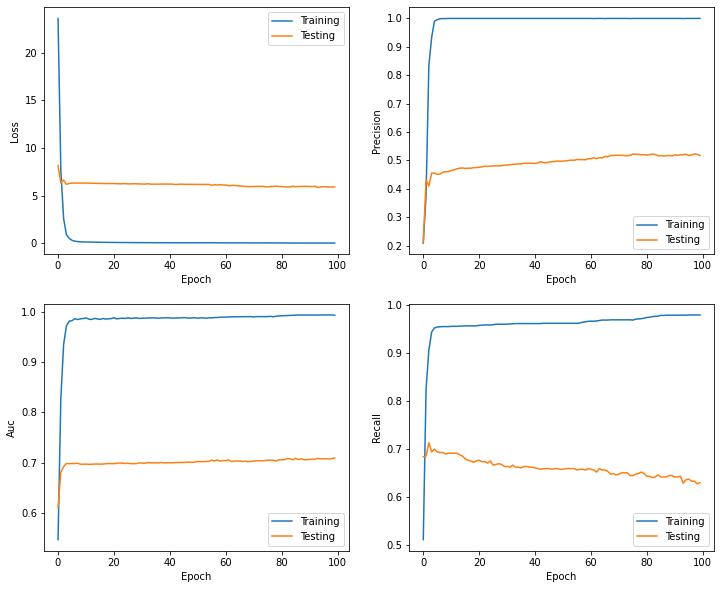

In [19]:
plot_metrics(history)

In [20]:
train_predictions_baseline = model.predict(X_train, batch_size=80)
test_predictions_baseline = model.predict(X_test, batch_size=80)

In [21]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Legitimate Transactions Detected (True Negatives):  75
Legitimate Transactions Incorrectly Detected (False Positives):  2101
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  688
Total Fraudulent Transactions:  688


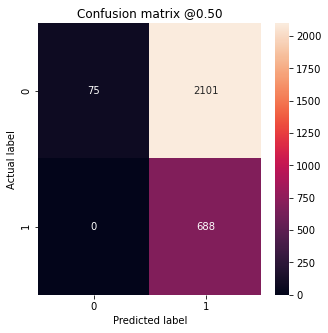

In [22]:
plot_cm(y_test, test_predictions_baseline)